# Comparación de modelos

In [1]:
import arviz as az
import matplotlib.pyplot as plt
from matplotlib.ticker import FormatStrFormatter
import numpy as np
import preliz as pz
import pymc as pm
from scipy.special import betaln

In [2]:
az.style.use('arviz-doc')

> "Un mapa no es el territorio que representa, pero si es correcto, tiene una estructura similar a la del territorio" - Alfred Korzybski

Todos los modelos son erróneos, en el sentido de que solo son aproximaciones que se utilizan para intentar comprender un problema a través de datos y no una copia literal del _mundo real_. Si bien todos los modelos son incorrectos, no todos los modelos son igualmente incorrectos; algunos modelos serán mejores que otros al describir los mismos datos. Incluso algunos modelos serán mejores que otros solo para cierto rango o subconjunto de los datos.

En los capítulos anteriores, centramos nuestra atención en el problema de inferencia, es decir, cómo _aprender_ el valor de los parámetros a partir de los datos. En este capítulo, nos centraremos en un problema complementario: cómo comparar dos o más modelos utilizados para explicar los mismos datos. Como veremos, este no es un problema trivial y, al mismo tiempo, es un problema central en el análisis de datos.

En el presente capítulo, exploraremos los siguientes temas:

* _Overfitting_ y _underfitting_
* Validación cruzada
* Factores de Bayes
* Regularización

## Pruebas predictivas a posteriori

Previamente hemos presentado y discutido las pruebas predictivas a posteriori como una forma de evaluar qué tan bien los modelos explican los mismos datos que se usan para ajustar al modelo. El propósito de este tipo de pruebas no es el de dictaminar que un modelo es incorrecto; ¡Esto ya lo sabemos! El objetivo del ejercicio es comprender qué tan bien estamos capturando los datos. Es frecuente que capturemos diferentes aspectos de los datos de diferentes maneras. Al realizar pruebas predictivas a posteriori, esperamos comprender mejor las limitaciones de un modelo, ya sea para tenerlas en cuenta o para intentar mejorar el modelo. Es esperable que un modelo no sea capaz de reproducir todos los aspectos de un problema y, por lo general, esto no es un problema ya que los modelos se construyen con un propósito en mente. Una prueba predictiva a posteriori es una forma de evaluar ese propósito, por lo tanto, si tenemos más de un modelo, podemos compararlos mediante pruebas predictivas a posteriori.


Veamos un ejemplo sencillo. Tenemos un conjunto de datos `x` e `y`. Vamos a ajustar estos datos con un modelo lineal:

$$
y = \alpha + \beta x
$$

Y un polinomio de orden 2:

$$
y = \alpha + \beta_0 x + \beta_1 x^2
$$

En el siguiente bloque de código cargamos los datos en las variables `x` e `y` "apilamos" `x, x**2` y estandarizamos. 

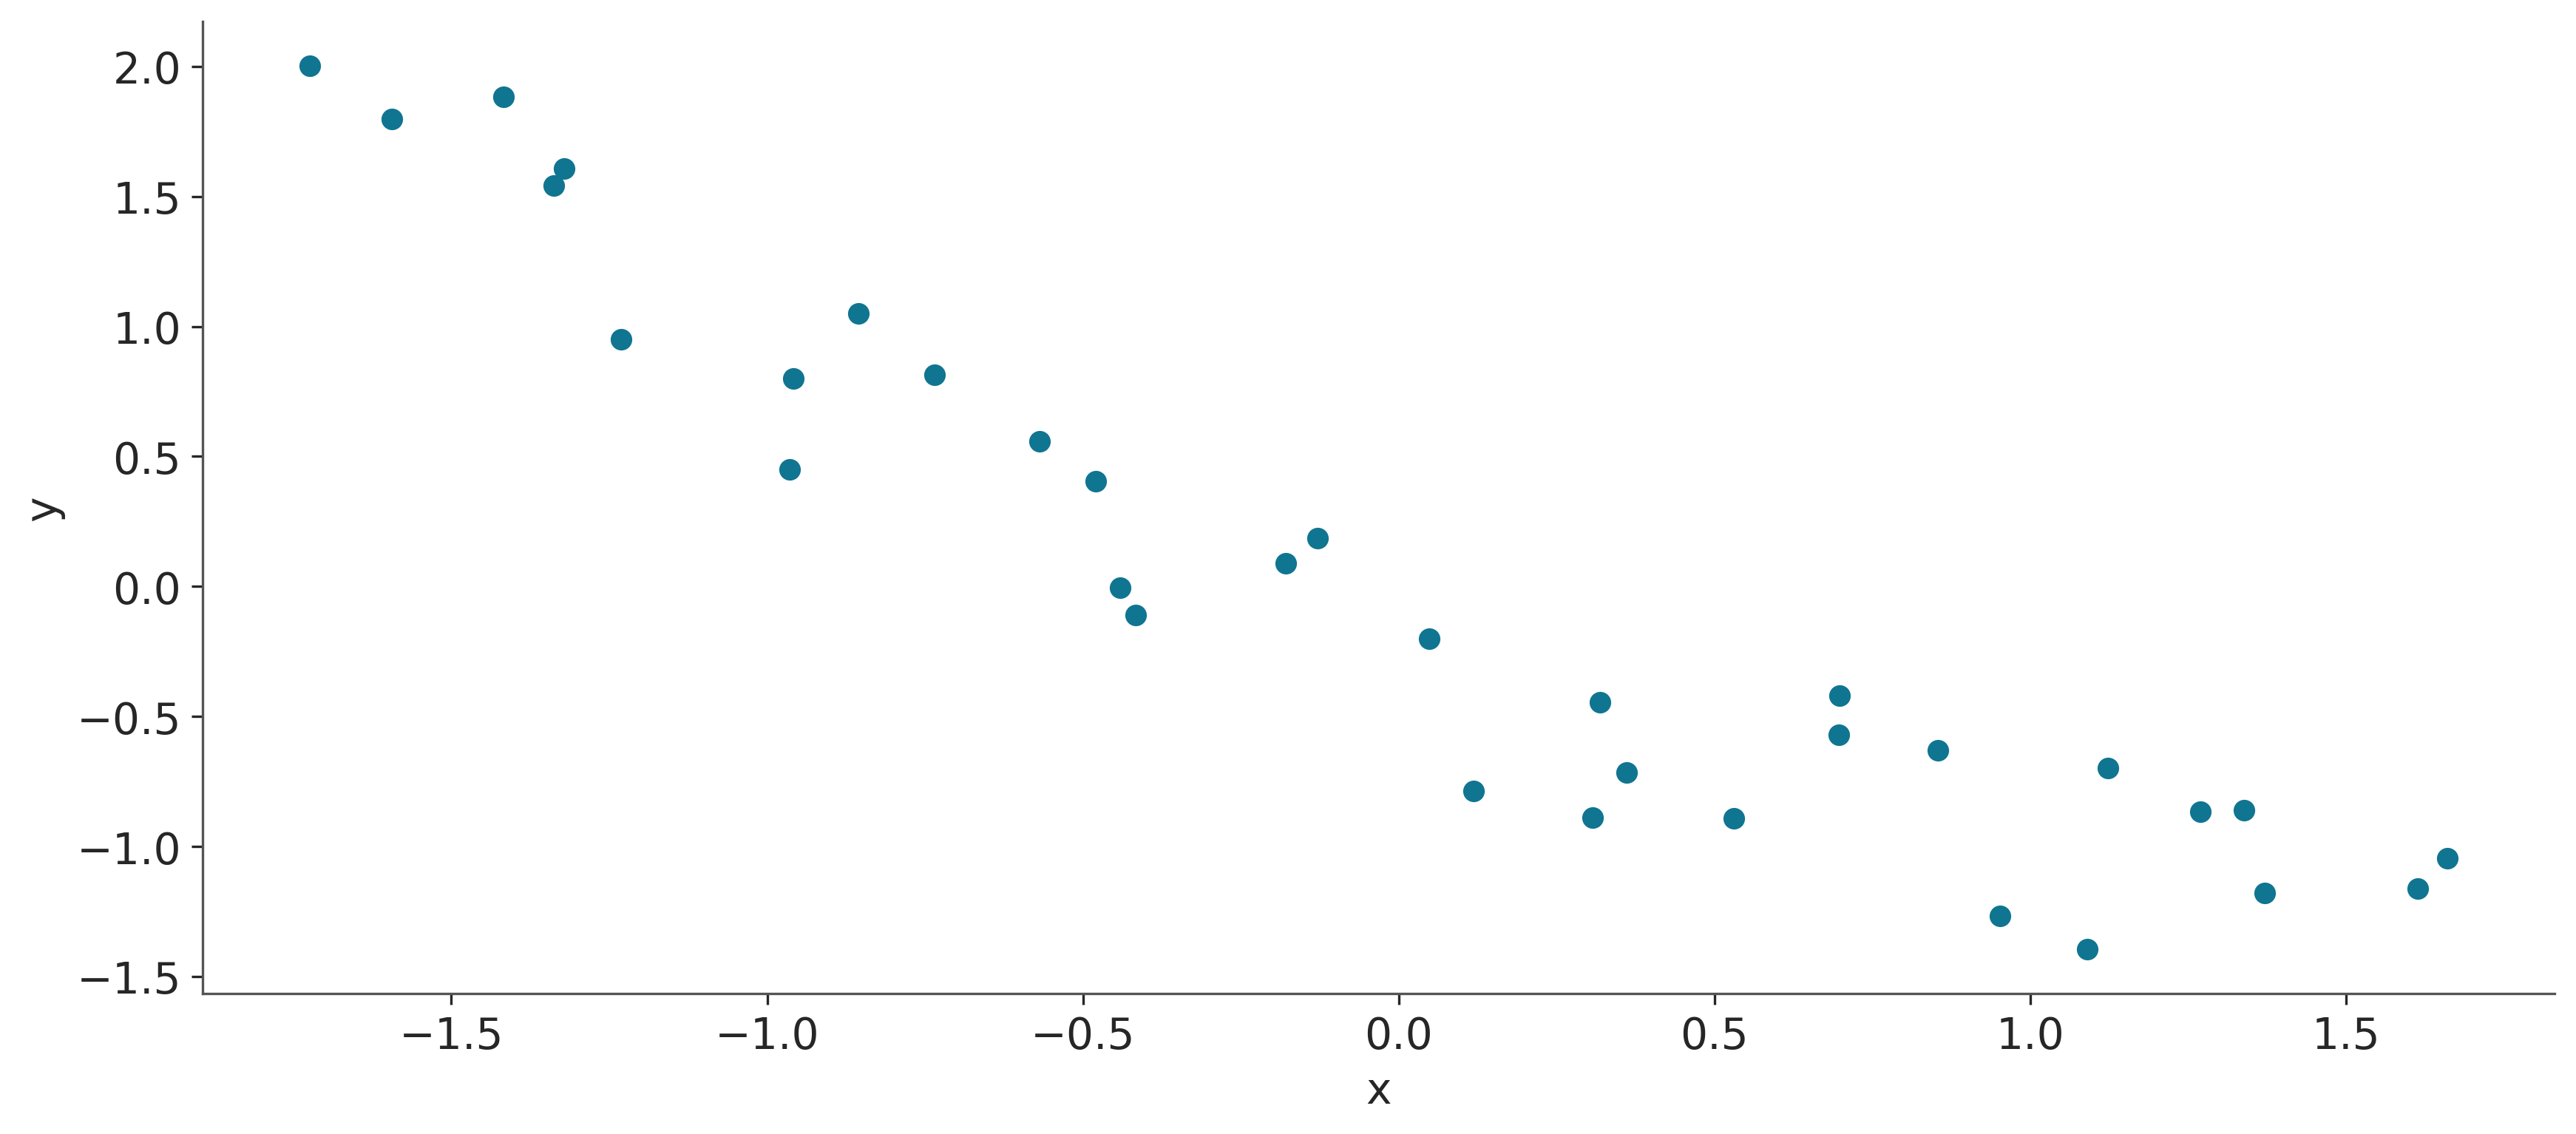

In [3]:
dummy_data = np.loadtxt('datos/dummy.csv')
x = dummy_data[:,0]
y = dummy_data[:,1]

order = 2
x_p = np.vstack([x**i for i in range(1, order+1)])
x_c = (x_p - x_p.mean(axis=1, keepdims=True)) / x_p.std(axis=1, keepdims=True)
y_c = (y - y.mean()) / y.std()
plt.scatter(x_c[0], y_c)
plt.xlabel('x')
plt.ylabel('y');

Ahora, vamos a ajustar estos datos con dos modelos ligeramente diferentes, uno lineal y el otro un polinomio de orden 2, también conocido como modelo parabólico o cuadrático:

In [4]:
with pm.Model() as model_l:
    α = pm.Normal('α', mu=0, sigma=1)
    β = pm.Normal('β', mu=0, sigma=10)
    ϵ = pm.HalfNormal('ϵ', 5)

    μ = α + β * x_c[0]
    
    y_pred = pm.Normal('y_pred', mu=μ, sigma=ϵ, observed=y_c)

    idata_l = pm.sample(2000, idata_kwargs={"log_likelihood": True})
    idata_l.extend(pm.sample_posterior_predictive(idata_l))

with pm.Model() as model_p:
    α = pm.Normal('α', mu=0, sigma=1)
    β = pm.Normal('β', mu=0, sigma=10, shape=order)
    ϵ = pm.HalfNormal('ϵ', 5)

    μ = α + pm.math.dot(β, x_c)
    
    y_pred = pm.Normal('y_pred', mu=μ, sigma=ϵ, observed=y_c)

    idata_p = pm.sample(2000, idata_kwargs={"log_likelihood": True})
    idata_p.extend(pm.sample_posterior_predictive(idata_p))


Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (4 chains in 4 jobs)
NUTS: [α, β, ϵ]


Sampling 4 chains for 1_000 tune and 2_000 draw iterations (4_000 + 8_000 draws total) took 2 seconds.
Sampling: [y_pred]


Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (4 chains in 4 jobs)
NUTS: [α, β, ϵ]


Sampling 4 chains for 1_000 tune and 2_000 draw iterations (4_000 + 8_000 draws total) took 4 seconds.
Sampling: [y_pred]


Ahora, vamos a visualizar el ajuste para ambos modelos:

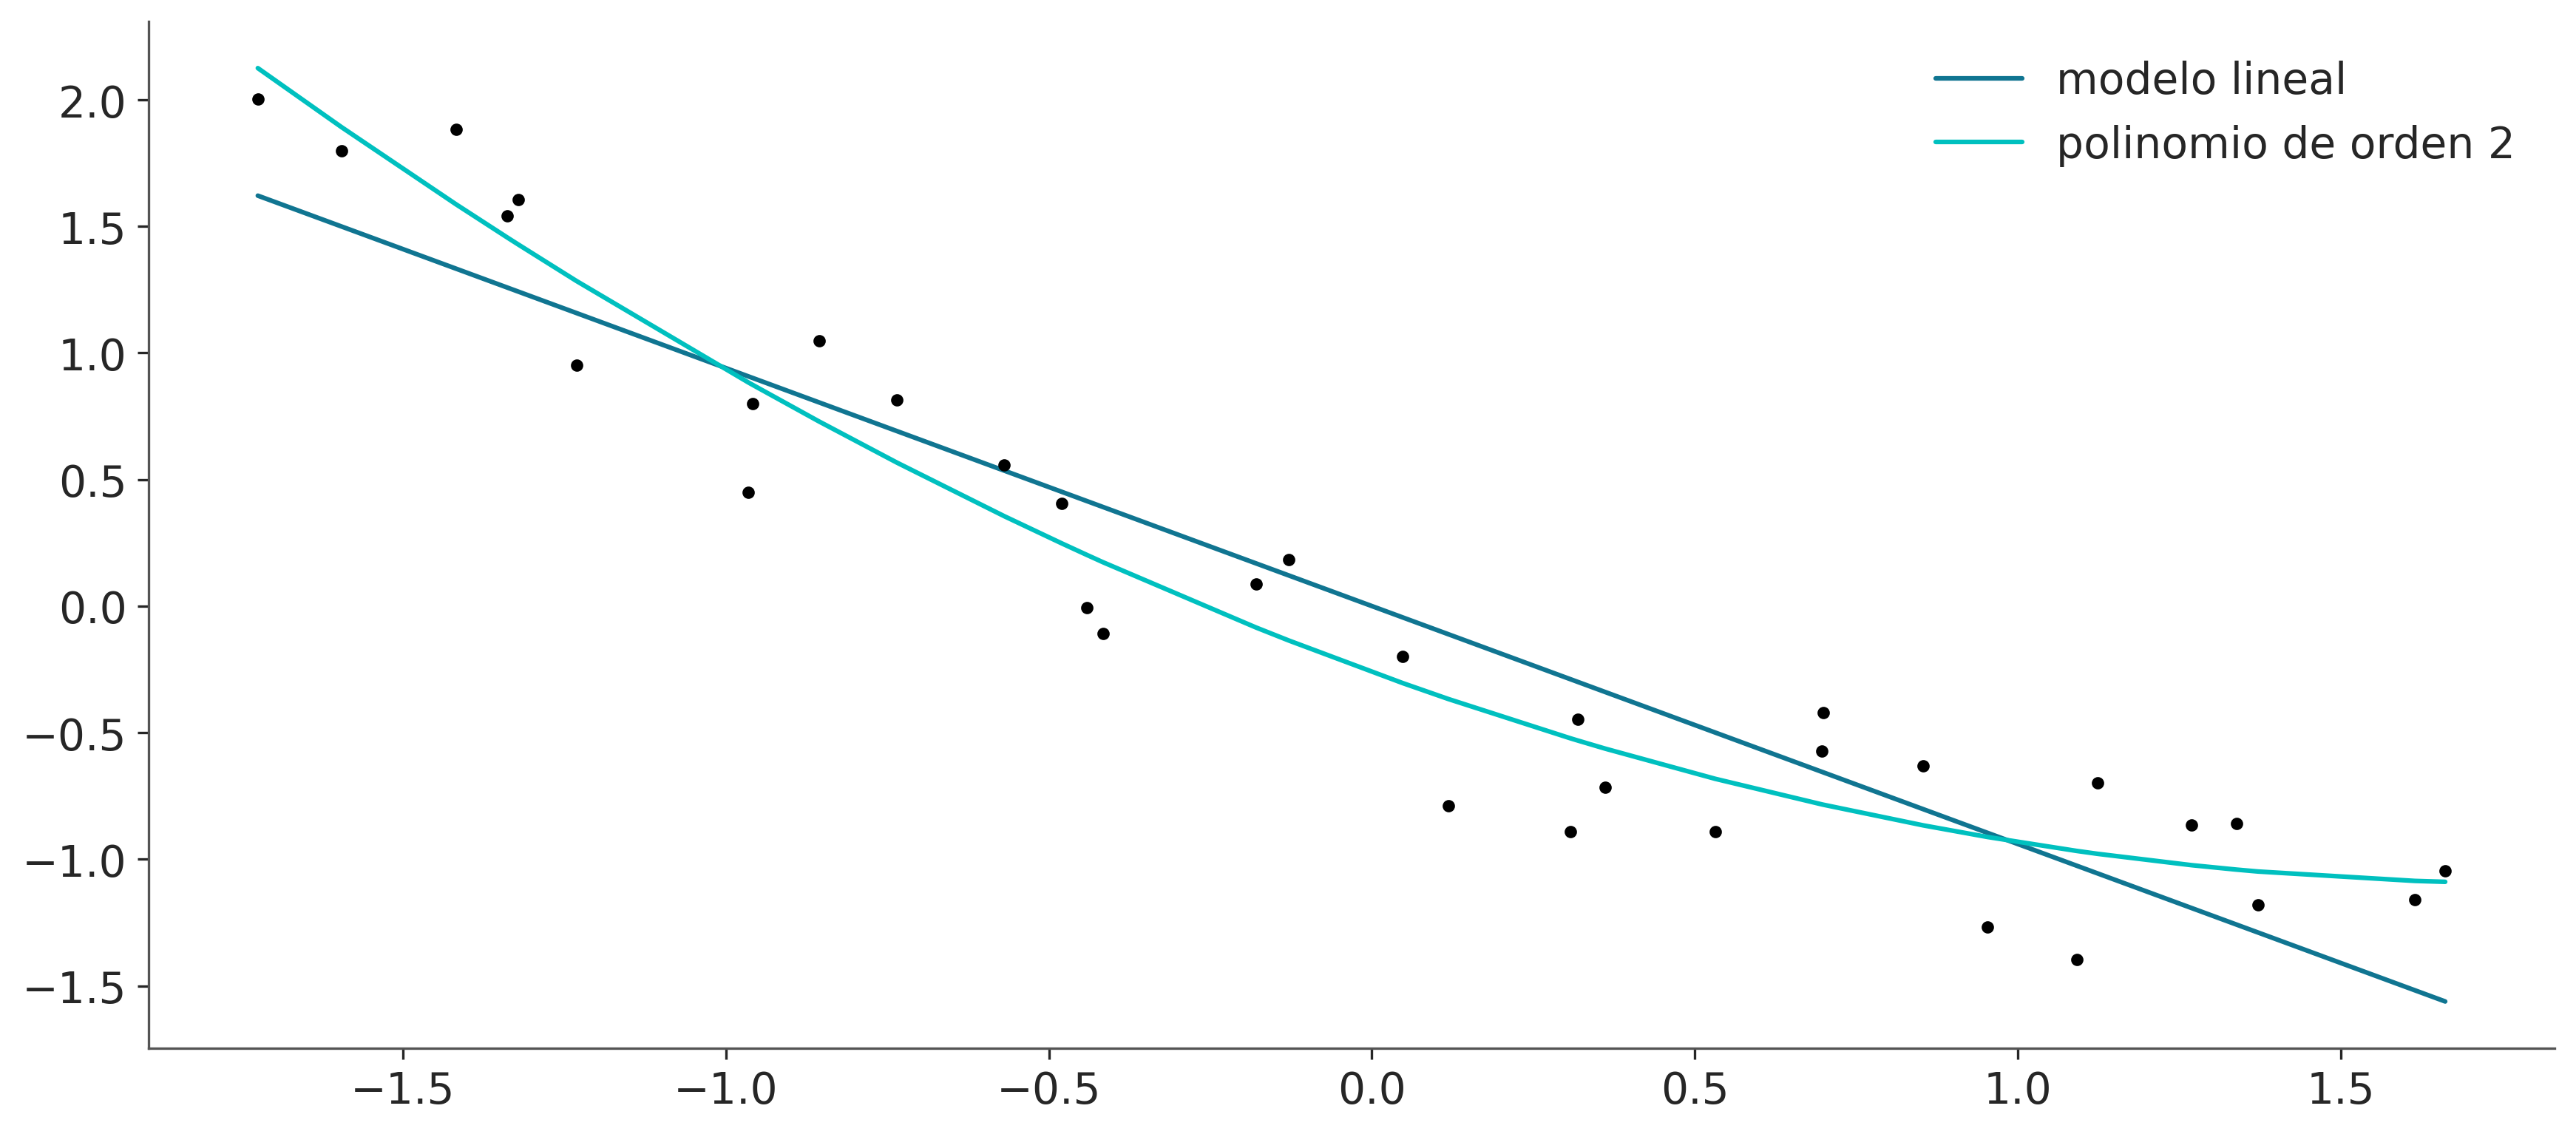

In [5]:
x_new = np.linspace(x_c[0].min(), x_c[0].max(), 100)

posterior_l = az.extract(idata_l)
posterior_p = az.extract(idata_p)

α_l_post = posterior_l['α'].mean().item()
β_l_post = posterior_l['β'].mean().item()
y_l_post = α_l_post + β_l_post *  x_new

plt.plot(x_new, y_l_post, 'C0', label='modelo lineal')

α_p_post = posterior_p['α'].mean().item()
β_p_post = posterior_p['β'].mean("sample")
idx = np.argsort(x_c[0])
y_p_post = α_p_post + np.dot(β_p_post, x_c)

plt.plot(x_c[0][idx], y_p_post[idx], 'C1', label=f'polinomio de orden {order}')

plt.plot(x_c[0], y_c, "k.")
plt.legend();

Ambos modelos parecen brindar ajustes razonables, aunque el modelo de orden 2 parece estar haciendo un mejor trabajo, pero el modelo lineal no es tan malo. 

En el mismo sentido la siguiente figura muestra un mejor acuerdo del ajuste polinomial sobre el lineal

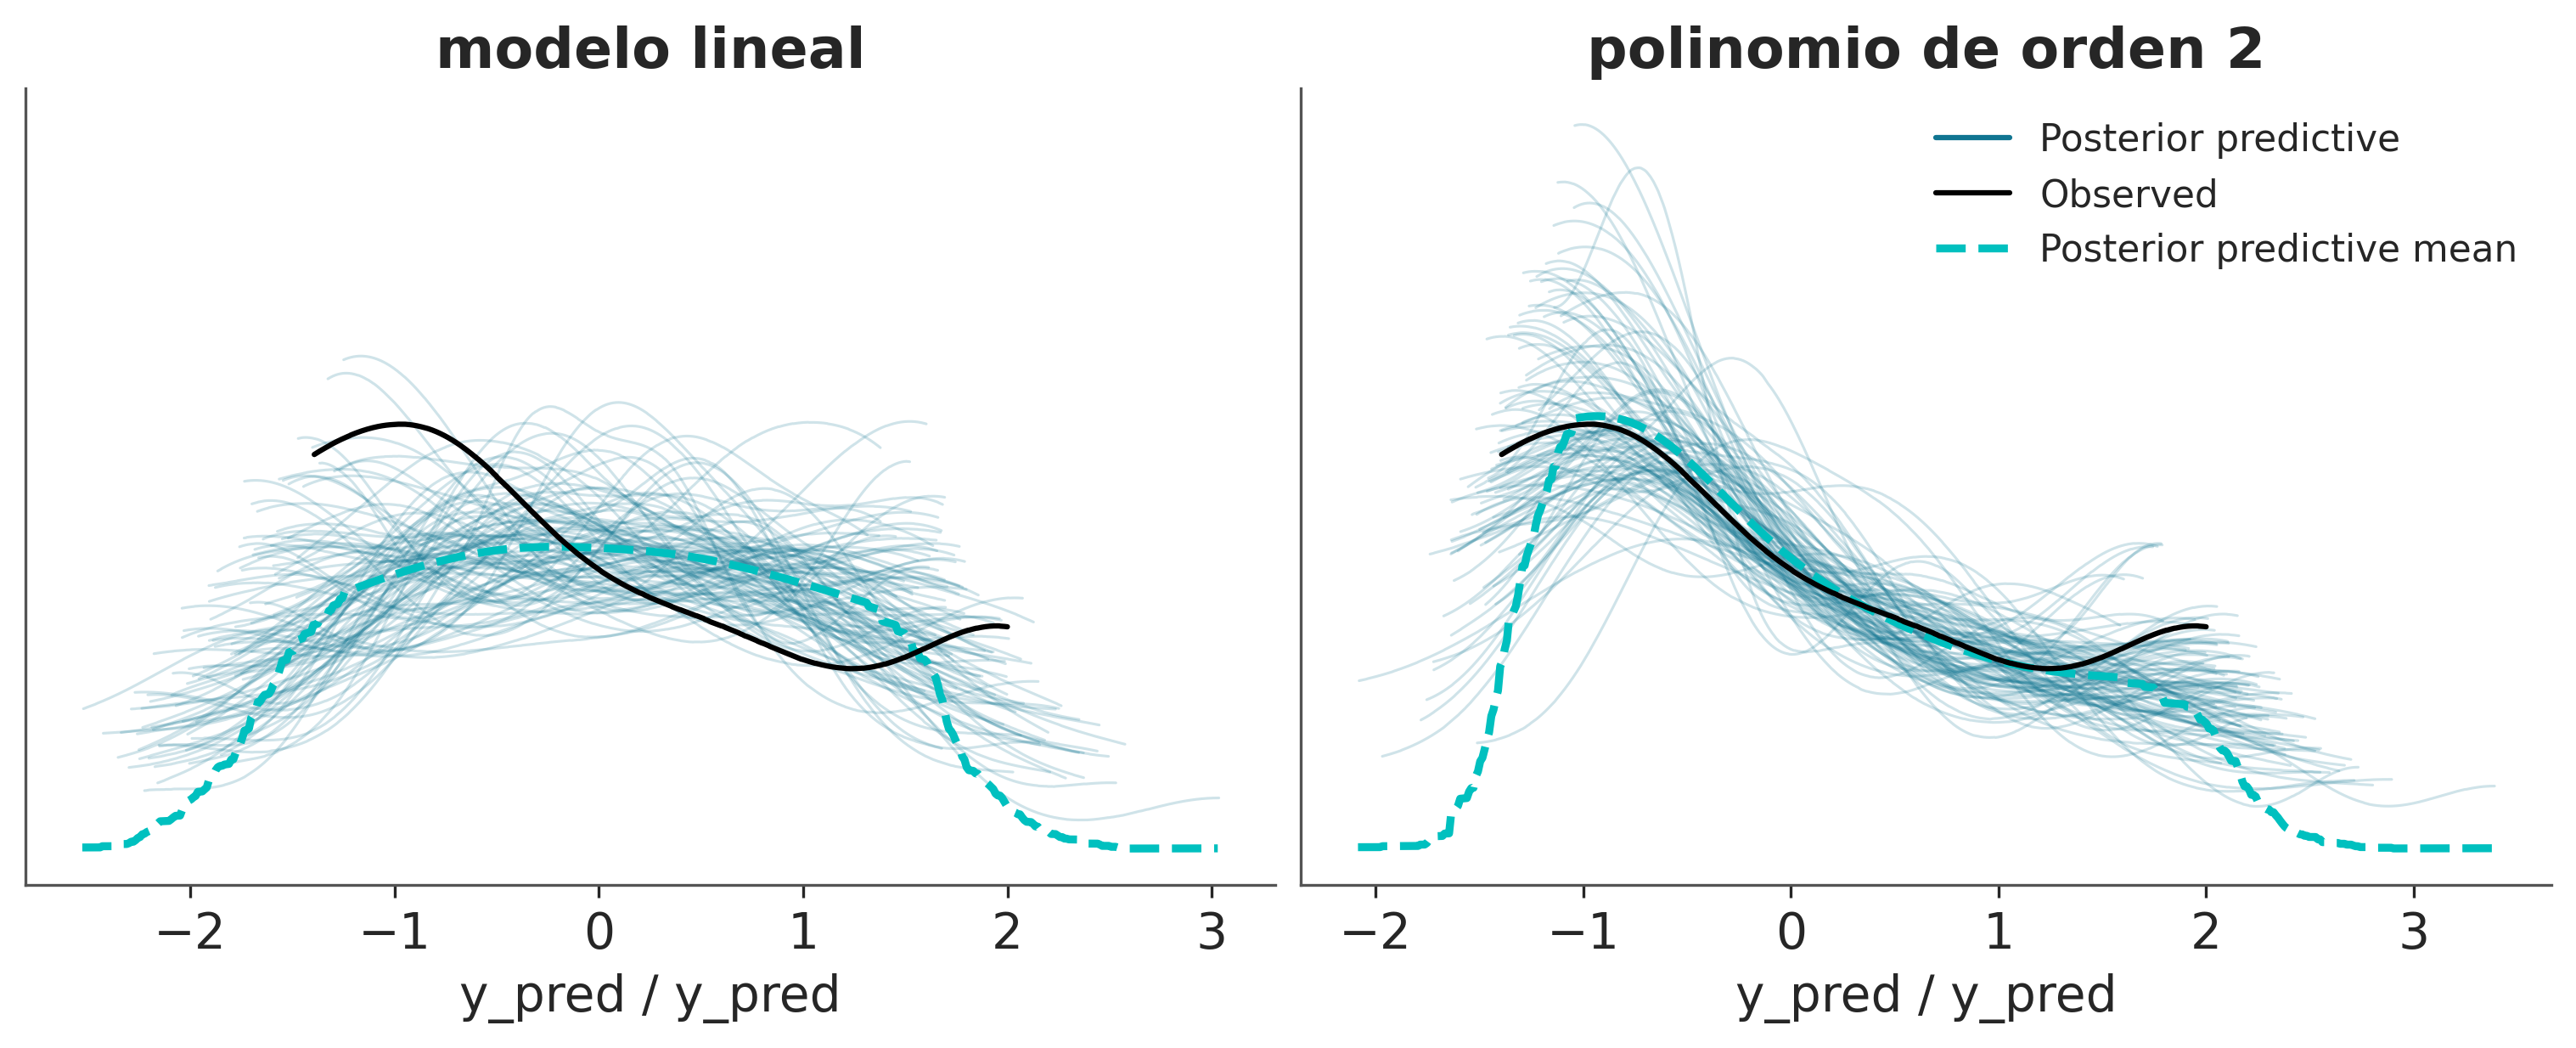

In [6]:
_, axes = plt.subplots(1, 2, figsize=(10, 4), sharey=True)
az.plot_ppc(idata_l, num_pp_samples=100, ax=axes[0], legend=False)
axes[0].set_title('modelo lineal')
az.plot_ppc(idata_p, num_pp_samples=100, ax=axes[1]);
axes[1].set_title(f'polinomio de orden {order}');

En vez de comparar directamente la distribución de datos observados versus la distribución predicha podemos comparar estadísticos sumarios.

En el panel superior de la siguiente figura se muestra 2 KDEs, representando la distribución de las medias predichas por los modelos. El punto sobre eje x indica el valor observado.

En el segundo panel lo mismo pero para el rango intercuartil. 

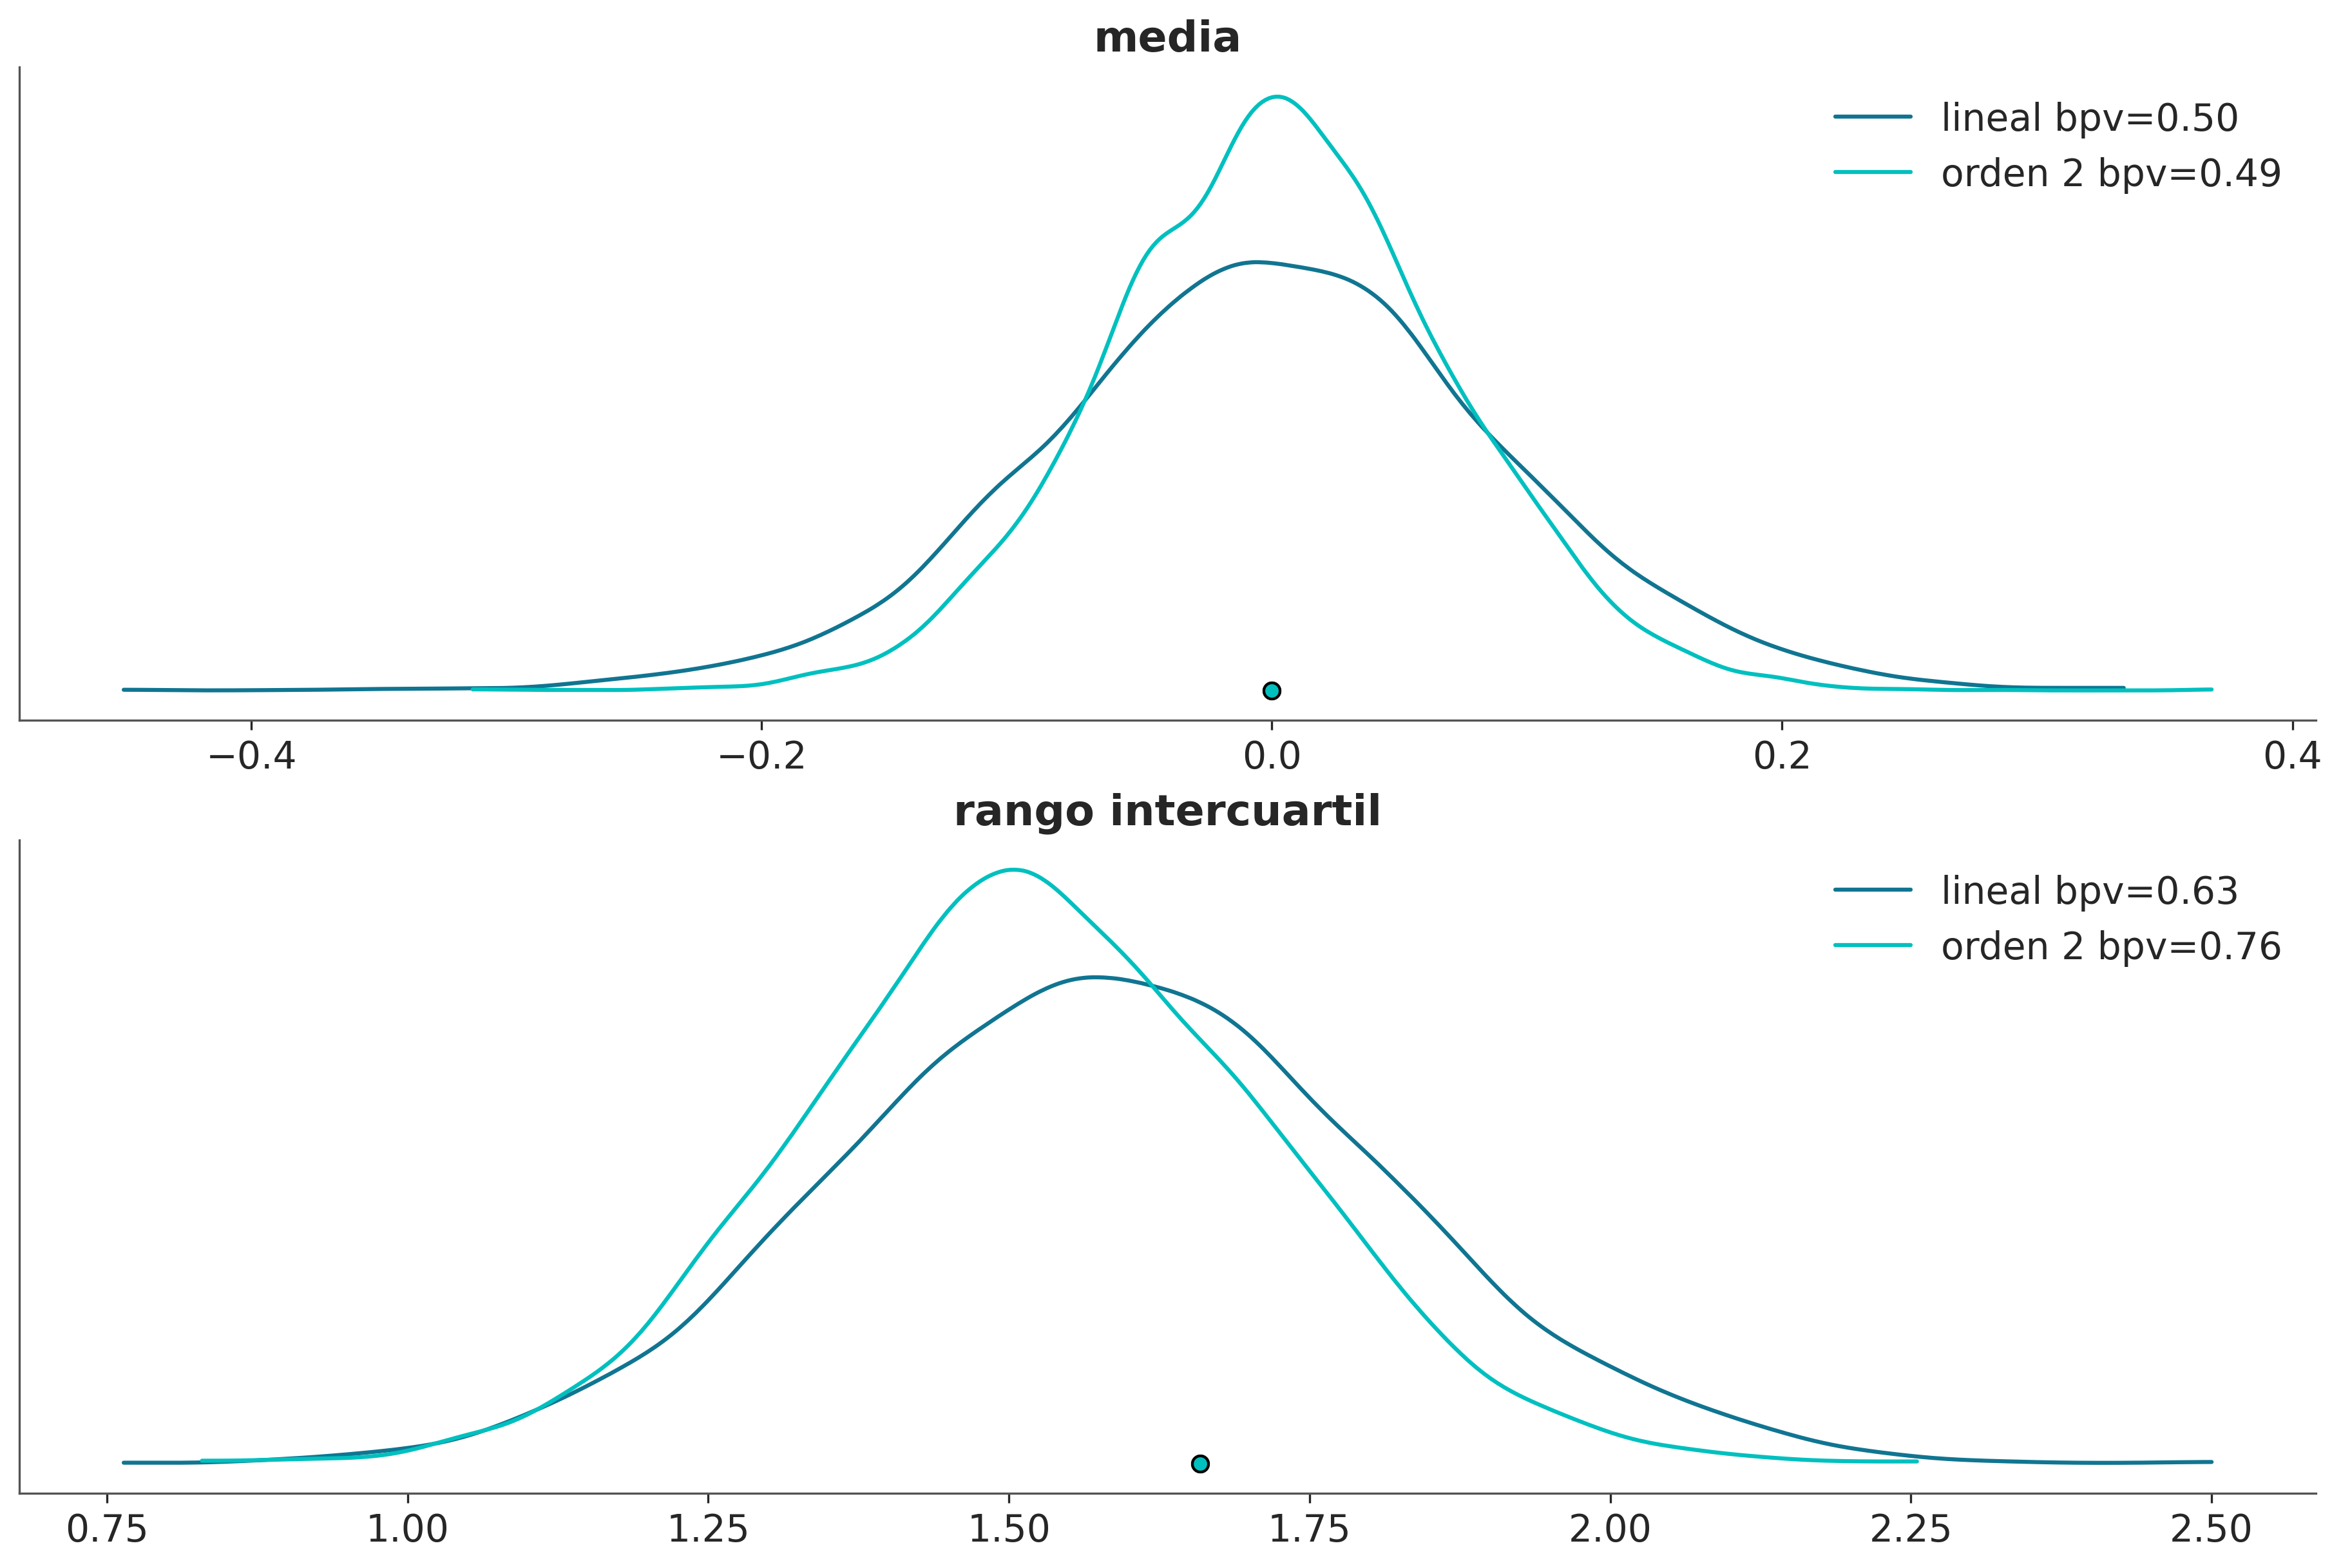

In [7]:
fig, axes = plt.subplots(2, 1, figsize=(12, 8), sharey="row")
colors = ["C0", "C1"]
titles = ["media", "rango intercuartil"]
modelos = ["lineal", f'orden {order}']
idatas = [idata_l, idata_p]

def iqr(x, a=-1):
    return np.subtract(*np.percentile(x, [75, 25], axis=a))

for idata, c in zip(idatas, colors):
    az.plot_bpv(idata, kind="t_stat", t_stat="mean", ax=axes[0], color=c)
    

for idata, c in zip(idatas, colors):
    az.plot_bpv(idata, kind="t_stat", t_stat=iqr, ax=axes[1], color=c)

for ax, title, in zip(axes, titles):
    ax.set_title(title)
    for idx, (c, modelo) in enumerate(zip(colors, modelos)):
        ax.legend_.legend_handles [idx]._alpha = 1
        ax.legend_.legend_handles [idx]._color = c
        ax.legend_._loc = 1
        ax.legend_.texts[idx]._text = modelo + " " + ax.legend_.texts[idx]._text

En la figura anterior también se incluyen unos valores llamados bpv, por Bayesian p-value. Los bpv son una forma numérica de resumir una comparación entre datos simulados y datos reales. Para obtenerlos se elige un estadístico sumario $T$, como por ejemplo la la media, mediana, desviación estándar etc. Luego se calcula $T$ para los datos observados $T_{\text{obs}}$ y para los datos simulados $T_{\text{sim}}$. Luego podemos hacernos dos preguntas:

1. Cual es la probabilidad que $T_{\text{sim}}$ sea menor o igual a $T_{\text{obs}}$?. Si los valores observados concuerdan con los predichos, el valor esperado será 0.5. Es decir la mitad de las predicciones están por debajo y la mitad por encima de lo observado. Esta cantidad es lo que se conoce como _valor p Bayesiano_.

$$\text{valor p Bayesiano} \triangleq p(T_{\text{sim}} \le T_{\text{obs}}  \mid \tilde Y)$$

Para quienes estén familiarizados con los _valores p_ y su uso en estadística frecuentista van un par de aclaraciones. Lo **Bayesiano** de estos _valores p_ es que NO estamos usando una distribución de muestreo sino _la distribución predictiva a posteriori_. Y una diferencia importante con la versión frecuentista es que en este caso no estamos haciendo una prueba de hipótesis nula, ni intentando declarar que una diferencia es "significativa".

En la figura anterior $T$ es la media (panel superior) o el rango interquartil (panel inferior). En este ejemplo es razonable que la media _de bien_ ya que el modelo lineal está construido para capturar la media. Si $T$ fuese la mediana, observaríamos diferencias algo más grandes. En general un estadístico que sea _ortogonal_ a lo que el modelo ajusta de forma directa será más informativo para evaluar al modelo. Ante la duda puede ser conveniente evaluar más de un estadístico. En general es útil preguntarse que aspectos de los datos nos interesa capturar mejor.


2. Otra forma de usar los bpv, es preguntar para **cada valor** observado, cual es la probabilidad de predecir un valor menor o igual. Si el modelo está bien calibrado la probabilidad debería ser la misma para todos los valores. Es decir para cualquier observación que tomemos deberíamos encontrar tantas simulaciones por encima como por debajo de ese valor.  En definitiva deberíamos esperar una distribución uniforme. En la siguiente figura se muestran las distribuciones para el modelo lineal y polinomio de orden 2.  La linea blanca indica la distribución uniforme esperada y la banda gris indica las desviaciones esperadas dado el tamaño finito de la muestra. Se puede ver que ambos modelos son muy similares.

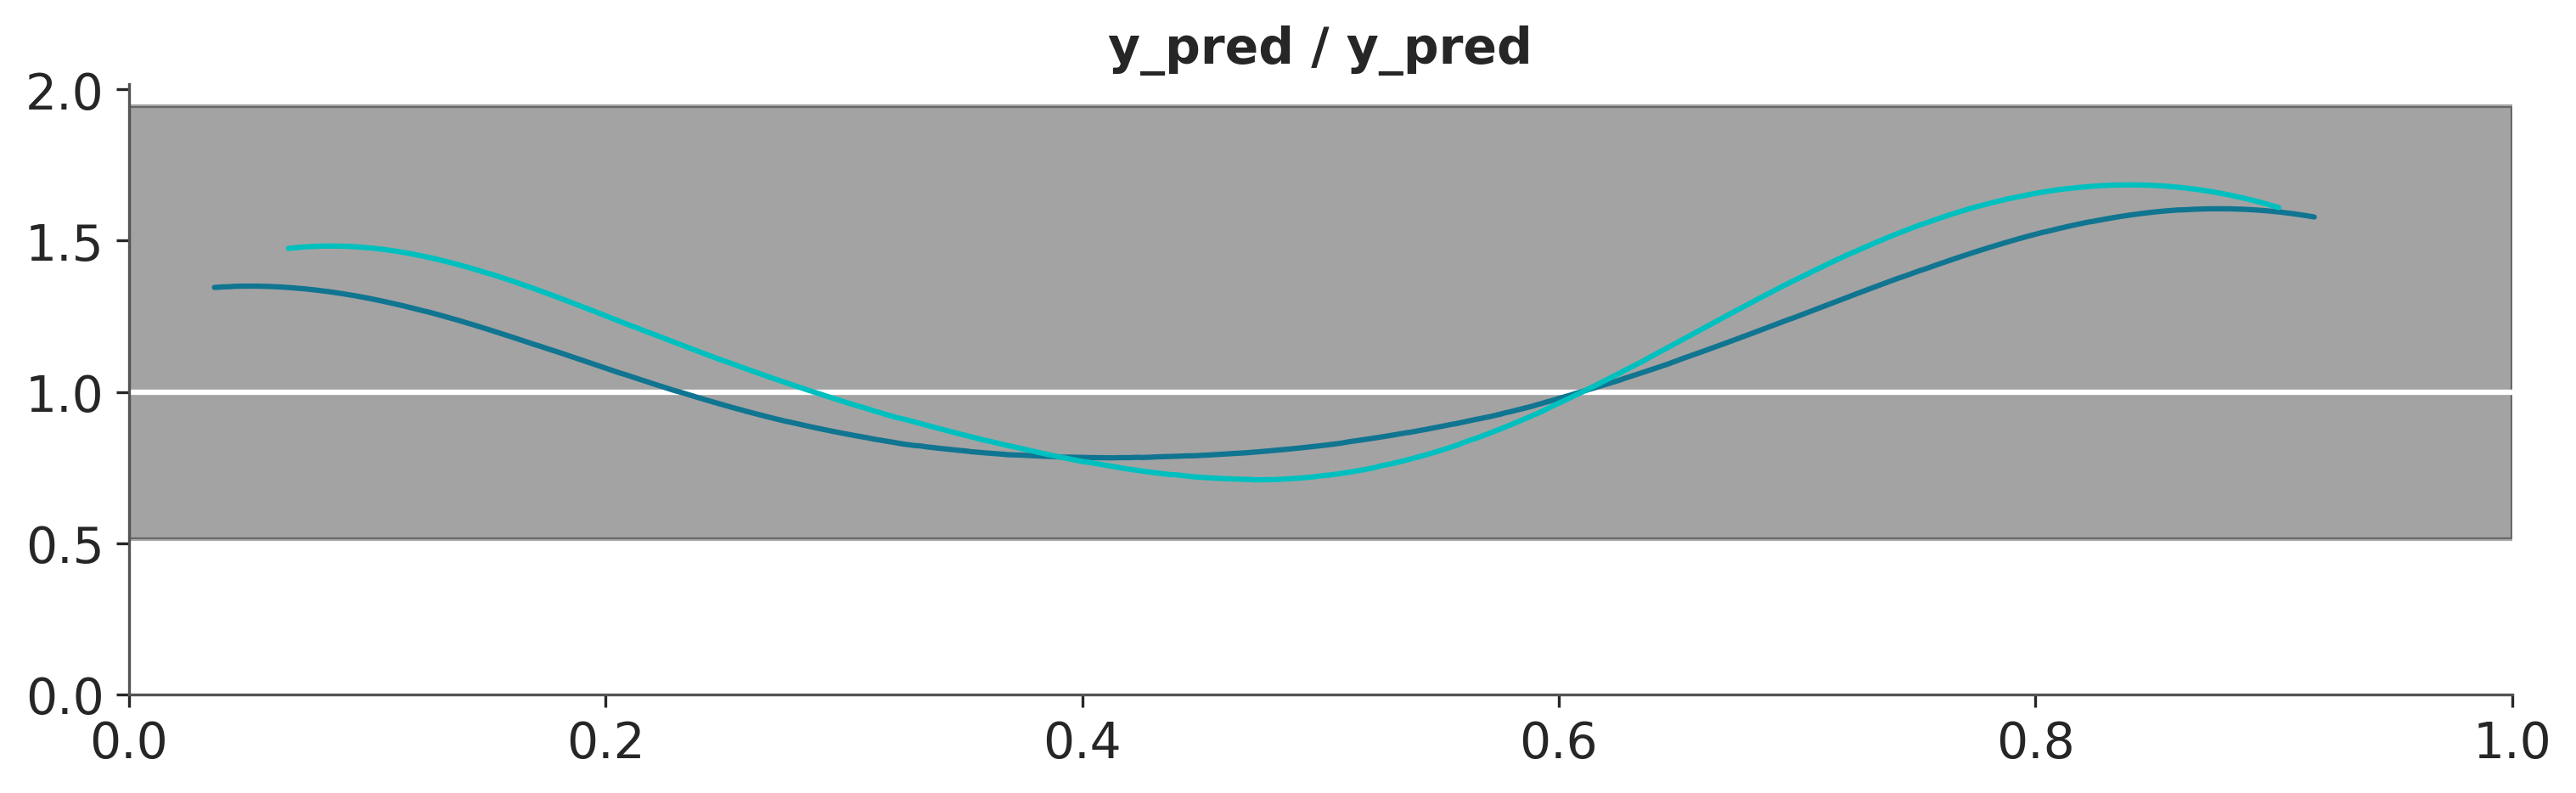

In [8]:
fig, ax = plt.subplots(figsize=(10, 3))

for idata, c in zip(idatas, colors):
    az.plot_bpv(idata, color=c, ax=ax)

Las pruebas predictivas _a posteriori_ ofrecen un marco muy flexible para evaluar y comparar modelos, ya sea utilizando gráficos o resúmenes numéricos como los _valores p bayesianos_, o incluso una combinación de ambos. El concepto es lo suficientemente general para permitir que una analista use su imaginación para encontrar diferentes formas de explorar la distribución predictiva _a posteriori_ y use las que mejor se ajusten a los fines de poder interpretar los datos y modelos.

En las siguientes secciones vamos a explorar otros métodos para comparar modelos.

## El equilibro entre simplicidad y exactitud

Al elegir entre explicaciones alternativas, existe un principio conocido como la navaja de Occam. En lineas muy generales este principio establece que dadas dos o más explicaciones equivalentes para el mismo fenómeno, la más simple es la explicación preferida. Un criterio común de simplicidad es la cantidad de parámetros de un modelo.

Hay muchas justificaciones para esta heurística, no vamos a discutir ninguna simplemente vamos a aceptarla como una guía razonable.

Otro factor que generalmente debemos tener en cuenta al comparar modelos es su exactitud, es decir, qué tan bueno es un modelo ajustando los datos. Según este criterio si tenemos dos (o más) modelos y uno de ellos explica los datos mejor que el otro, entonces ese es el modelo preferido. 

Intuitivamente, parece que al comparar modelos, tendemos a preferir aquellos que mejor ajusten los datos y aquellos que sean más simples. ¿Pero que hacer si estos dos principios se contraponen? O de forma más general, ¿Existe una forma cuantitativa de contemplar ambas contribuciones? La respuesta corta es que si, de hecho hay más de una forma de hacerlo. Pero antes veamos un ejemplo a fin de generar mayor intuición.

### Muchos parámetros (pueden) conducir a sobreajuste

Vamos a comenzar por combinar polinomios cada vez más complejos en un conjunto de datos muy simple. En lugar de utilizar la maquinaria Bayesiana, usaremos la aproximación de mínimos cuadrados para ajustar modelos lineales. 

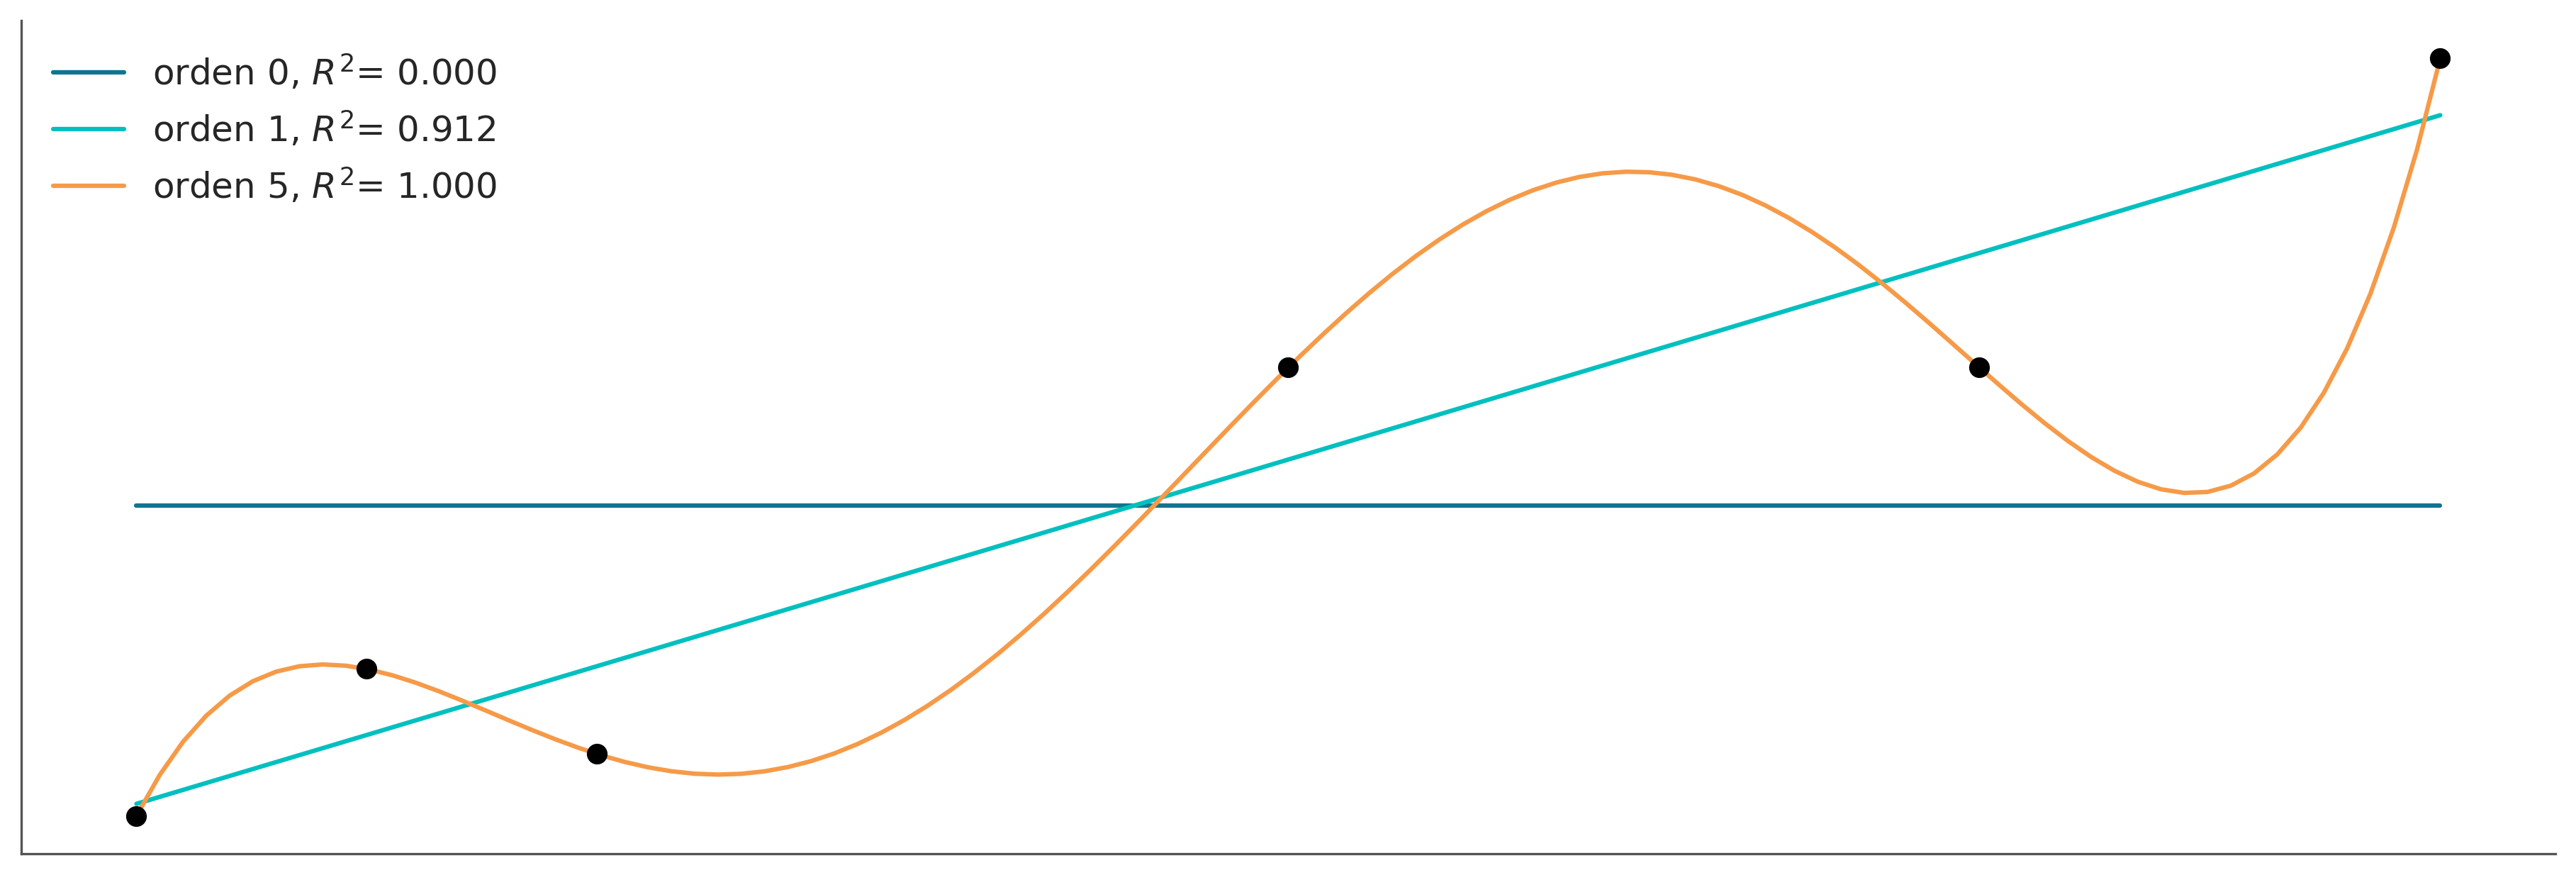

In [9]:
_, ax = plt.subplots(1, 1, figsize=(12, 4))


x0 = np.array([4., 5., 6., 9., 12, 14.])
y0 = np.array([4.2, 6.1, 5., 10., 10, 14.])

order = [0, 1, 5]
ax.plot(x0, y0, 'ko', zorder=3)


ax.set_yticks([])
ax.set_xticks([])

x_n = np.linspace(x0.min(), x0.max(), 100)
ps = []
for i in order:
    p = np.polynomial.Polynomial.fit(x0, y0, deg=i)
    ps.append(p)
    yhat = p(x0)
    ybar = np.mean(y0)
    ss_regression = np.sum((yhat-y0)**2)
    ss_total = np.sum((ybar-y0)**2)
    r2 = 1 - ss_regression / ss_total
    ax.plot(x_n, p(x_n), label=f'orden {i}, $R^2$= {r2:.3f}')

    
ax.legend(loc=2, fontsize=12);

De la figura anterior podemos ver que el aumento de la complejidad del modelo se acompaña de una mayor exactitud reflejada en el coeficiente de determinación R². De hecho, podemos ver que el polinomio de orden 5 se ajusta perfectamente a los datos, obteniendo un R²=1. 

¿Por qué el polinomio de grado 5 puede capturar los datos sin perder uno solo de ellos? La razón es que tenemos el mismo número de parámetros que de datos es decir 6. Por lo tanto, el modelo está actuando simplemente como una forma alternativa de expresar los datos. El modelo no está aprendiendo algo sobre los datos, ¡Está memorizando los datos! A partir de este simple ejemplo, podemos ver que un modelo con mayor ajuste no siempre es lo ideal.


Ahora agregaremos dos datos nuevos y sin volver a ajustar los modelos veremos como cambia el R². Se puede ver que al modelo lineal le va mejor en este caso que al polinomial.

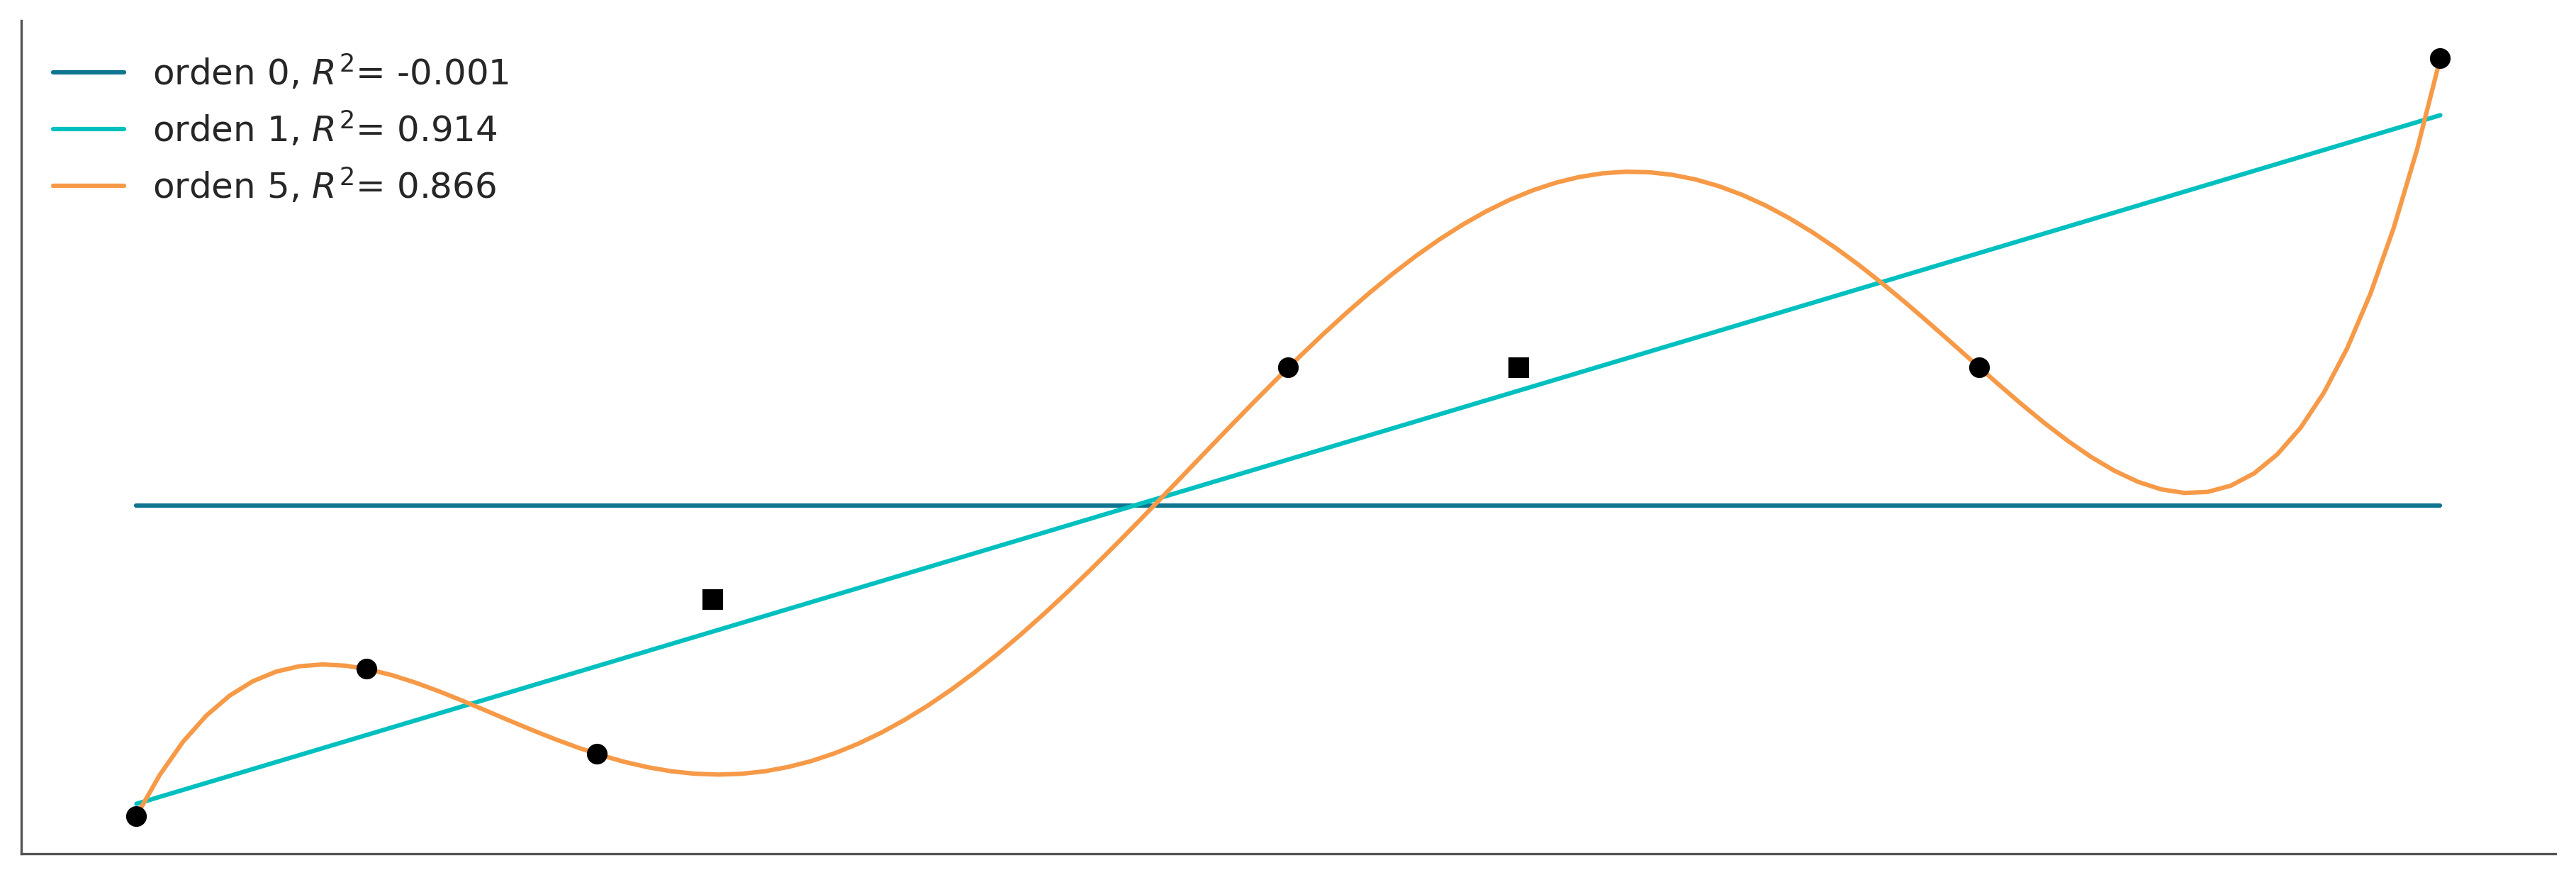

In [10]:
_, ax = plt.subplots( figsize=(12, 4))
x_ = np.array([6.5, 10])
y_ = np.array([7, 10])

ax.plot(x0, y0, 'ko', zorder=3)
ax.plot(x_, y_, 'ks', zorder=3)

ax.set_yticks([])
ax.set_xticks([])

x1 = np.concatenate((x0, x_))
y1 = np.concatenate((y0, y_))

for idx, i in enumerate(order):
    yhat = ps[idx](x1)
    ybar = np.mean(y1)
    ss_regression = np.sum((yhat-y1)**2)
    ss_total = np.sum((ybar-y1)**2)
    r2 = 1 - ss_regression / ss_total
    ax.plot(x_n, ps[idx](x_n), label=f'orden {i}, $R^2$= {r2:.3f}')

    
ax.legend(loc=2, fontsize=12);

Cuando un modelo ajusta muy bien, el conjunto de datos utilizado para aprender los parámetros de ese modelo, pero muy mal otros conjuntos de datos, decimos que tenemos sobreajuste (overfitting). Este es un problema muy común al analizar datos.

Una forma muy útil de pensar el sobreajuste es considerar que un conjunto de datos tiene dos componentes; la señal y el ruido. La señal es lo que queremos capturar (o aprender) de los datos. Si usamos un conjunto de datos es porque creemos que hay una señal allí, de lo contrario será un ejercicio fútil. El ruido, en cambio, no es útil y es el producto de los errores de medición, las limitaciones en la forma en que se generaron o capturaron los datos, la presencia de datos corruptos, etc. Un modelo sobreajusta cuando es tan flexible (para un conjunto de datos) que es capaz de _aprender_ el ruido. Esto tiene como consecuencia que la señal queda oculta.

Esta es una justificación práctica para la navaja de Occam. Y nos advierte que al menos en principio, siempre es posible crear un modelo tan complejo que explique todos los detalles, incluso los más irrelevantes. Tal como en el Imperio descripto por Borges, donde los cartógrafos alcanzaron tal nivel de sofisticación que crearon un mapa del Imperio cuyo tamaño era el del propio Imperio, y que coincidía punto por punto con él.

### Muy pocos parámetros conducen a un subajuste

Continuando con el mismo ejemplo pero en el otro extremo de complejidad, tenemos el modelo de orden 0. Este modelo es simplemente una Gaussiana disfrazada de modelo lineal. Este modelo solo es capaz de capturar el valor de la media de $Y$, y es por lo tanto totalente indiferente a los valores de $x$. Decimos que este modelo ha subajustado los datos.

## Medidas de exactitud predictiva


_Todo debe hacerse tan simple como sea posible, pero no más simple_ es una cita que a menudo se atribuye a Einstein. Al igual que en una dieta saludable, al modelar tenemos que mantener un balance. Idealmente, nos gustaría tener un modelo que ni sub-ajuste ni sobre-ajuste los datos. De alguna forma hay que balancear simplicidad y bondad de ajuste.

En el ejemplo previo, es relativamente facil de ver que el modelo de orden 0 es _demasiado_ simple mientras que el modelo de orde 5 es _demasiado_ complejo. Pero que podemos decir de los otros dos modelos? Cómo podríamos establecer un ranking numérico de estos modelos? Para poder hacer esto necesitamos formalizar nuestra intuición sobre este balance entre simplicidad y exactitud

Veamos un par de términos que nos serán de utilidad.

* **Exactitud dentro de la muestra** (within-sample accuracy). La exactitud medida con los mismos datos usado para ajustar el modelo.
* **Exactitud fuera de la muestra** (out-of-sample accuracy). La exactitud medida con datos no usados para ajustar el modelo.

La exactitud dentro de la muestra será, en promedio, menor a la exactitud fuera de la muestra. Es por ello que usar la exactitud dentro de la muestra para evaluar un modelo en general conducirá a pensar que tenemos un mejor modelo de lo que realmente es. Utilizar la exactitud fuera de la muestra es por lo tanto una mejor idea para evitar engañarnos a nosotros mismos. Sin embargo, esta aproximación requiere dejar datos fuera del ajuste, lo cual es un lujo que en general no nos podemos dar. Ya que este es un problema central en el análisis de datos existen varias propuestas para abordarlo. Dos aproximaciones muy populares son:


* Validación cruzada: esta es una estrategia empírica basada en dividir los datos disponibles en subconjuntos separados que se utilizan para ajustar y evaluar de forma alternativa

* Criterios de información: este es un término general usado para referirse a varias expresiones que  aproximan la exactitud fuera de la muestra como la exactitud dentro de la muestra más un término que penaliza la complejidad del modelo.

### Validación cruzada

La validación cruzada es una solución simple y, en la mayoría de los casos, efectiva para comparar modelos. Tomamos nuestros datos y los dividimos en K porciones. Intentamos mantener las porciones más o menos iguales (en tamaño y, a veces, también en otras características, como, por ejemplo, un número igual de clases). Luego usamos K-1 porciones para entrenar el modelo y el resto para evaluarlo. Este proceso se repite sistemáticamente dejando, por cada iteración, una porción diferente fuera del conjunto de entrenamiento y usando esa porción como el conjunto de evaluación. Esto se repite hasta que hayamos completado K rondas de ajuste-evaluación. La exactitud del modelo será la del promedio a lo largo de las K rondas. Esto se conoce como validación cruzada K-fold. Por último, una vez que hemos relizado la validación cruzada, usamos todos los datos para ajustar por última vez nuestro modelo y este es el modelo que se utiliza para hacer predicciones o para cualquier otro fin.

<img src='img/cv.png' width=500 >

Cuando K es igual a la cantidad de puntos de datos, obtenemos lo que se conoce como _validación cruzada dejando uno afuera_ (LOOCV del inglés leave-one-out cross-validation). 

La validación cruzada es una práctica de rutina en _machine learning_. Y apenas hemos descripto los aspectos más esenciales de esta práctica. Para mayor información pueden leer The Hundred-Page Machine Learning Book](http://themlbook.com/)  o [Python Machine Learning](https://www.amazon.com/Python-Machine-Learning-scikit-learn-TensorFlow-ebook/dp/B0742K7HYF/ref=dp_ob_title_def), by Sebastian Raschka, o [Python Data Science Handbook](https://jakevdp.github.io/PythonDataScienceHandbook/) by Jake Vanderplas.

La validación cruzada es una idea muy simple y útil, pero para algunos modelos o para grandes cantidades de datos, el costo computacional de la validación cruzada puede estar más allá de nuestras posibilidades. Muchas personas han tratado de encontrar cantidades más simples de calcular que se aproximen a los resultados obtenidos con la validación cruzada o que funcionen en escenarios donde la validación cruzada no puede ser tan fácil de realizar. Y ese es el tema de la siguiente sección.

### Criterios de información


Los criterios de información son una colección de herramientas estrechamente relacionadas que se utilizan para comparar modelos en términos de la bondad del ajuste y de la complejidad del modelo. En otras palabras, los criterios de información formalizan la intuición que desarrollamos al comienzo del capítulo. 
La forma exacta en que se derivan estas cantidades tiene que ver con un campo conocido como [Teoría de la Información](http://www.inference.org.uk/mackay/itila/book.html).


Una forma intuitiva de medir qué tan bien un modelo se ajusta a los datos es calcular el error cuadrático medio entre los datos y las predicciones realizadas por el modelo:


$$\frac{1}{n} \sum_{i=1}^{n}  (y_i - \operatorname{E} (y_i \mid \theta))^2$$


$\operatorname{E} (y_i \mid \theta)$ es el valor predicho dados los parámetros estimados. Es importante notar que esto es esencialmente el promedio de la diferencia entre los datos observados y los predichos.
Tomar el cuadrado de los errores asegura que las diferencias no se cancelen y enfatiza grandes errores comparado con otros alternativas como por ejemplo calcular el valor absoluto.

El error cuadrático medio, puede resultarnos familiar ya que es muy popular. Pero si nos detenemos a reflexionar sobre esta cantidad veremos que en principio no tiene nada de especial y bien podríamos idear otras expresiones similares. Cuando adoptamos una aproximación probabilista vemos que una expresión más general (y *natural*) es la siguiente:

$$ \sum_{i=1}^{n} \log p(y_i \mid \theta)$$

Esto es, la suma (sobre $n$ datos) de los _likelihoods_ (en escala logarítmica). Esto es _natural_ por que al elegir un likelihood en un modelo estamos eleigiendo implícitamente una métrica para evaluar el ajuste del modelo. Cuando $p(y_i \mid \theta)$ es una gaussiana entonces la suma de log-likelihood será proporcional al error cuadrático medio.

#### Criterio de información de Akaike 

Este es un criterio de información muy conocido y ampliamente utilizado fuera del universo Bayesiano y se define como:

$$AIC = -2 \sum_{i=1}^{n} \log p(y_i \mid \hat{\theta}_{mle}) + 2 k $$

Donde, k es el número de parámetros del modelo y $\hat{\theta}_{mle}$ es la estimación por máxima verosimilitud para $\theta$. 


La estimación de máxima verosimilitud es una práctica común para los no-bayesianos y, en general, es equivalente a la estimación Bayesiana del máximo a posteriori (MAP) cuando se usan priors *planos*. Es importante notar que $\hat{\theta}_{mle} $ es una estimación puntual y no una distribución.

El factor $-2$ es tan solo una constante, y podríamos omitirla pero usualmente no se hace. Lo importante, desde el punto de vista práctico, es que el primer término toma en cuenta cuan bien el modelo ajusta los datos, mientras que el segundo término penaliza la complejidad del modelo. Por lo tanto si dos modelos ajustan los datos igualmente bien. AIC dice que deberemos elegir aquel modelo con el menor número de parámetros.


AIC funciona bien en enfoques no-bayesianos, pero de lo contrario es problemático. Una de las razones es que no utiliza la distribución a posteriori de $\theta$ y, por lo tanto, descarta información sobre la incertidumbre en la estimación. Además AIC, desde una pespectiva Bayesiana, asume que los priors son *planos* y, por lo tanto, AIC es incompatible con priors informativos y ligeramente informativos como los utilizados en este libro. Además, la cantidad de parámetros de un modelo no es una buena medida de la complejidad del mismo cuando se usan priors informativos o estructuras como la jerárquica ya que estas son formas de reducir la _cantidad efectiva de parámetros_, algo también conocido como *regularización*. Más adelante volveremos sobre esta idea de regularización.

#### Widely applicable information criterion

WAIC es algo así como la versión Bayesiana de AIC, al igual que este último WAIC se compone de dos términos uno que mide el ajuste y otro que penaliza. La siguiente expresión asume que la distribución a posteriori está representada como una muestra de tamaño S (como la obtenida de un método MCMC).

$$WAIC = -2 \sum_i^n \log \left(\frac{1}{S} \sum_{s=1}^S p(y_i \mid \theta^s) \right) + 2 \sum_i^n  \left( V_{s=1}^S \log p(y_i \mid \theta^s) \right)$$


El primer término es similar al criterio de Akaike, solo que evaluado para todas las observaciones y todas las muestras del posterior. El segundo término es un poco más difícil de justificar sin entrar en tecnicismos. Pero es también una forma de penalizar la complejidad del modelo. Lo importante desde el punto de vista práctico es que WAIC usa todo el posterior (y no una estimación puntual) para el cálculo de ambos términos, por lo que WAIC puede ser aplicado virtualmente a cualquier modelo Bayesiano.

#### Validación cruzada (aproximada)

El problema clave con la validación cruzada dejando uno fuera es que es muy costosa ya que tenemos que reajustar el modelo tantas veces como datos tengamos. Por suerte, es posible aproximarla con un solo ajuste a los datos! El método para hacer esto se llama "muestreo de importancia usando un suavizado de Pareto". El nombre es tan poco agraciado que en la práctica le decimos LOO. Conceptualmente lo que estamos tratando de calcular es:


$$
\text{ELPD}_\text{LOO-CV} = \sum_{i=1}^{n} \log
    \int \ p(y_i \mid \theta) \; p(\theta \mid y_{-i}) d\theta
$$

$$
\sum_{i}^{n} \log
    \left( \frac{1}{s}\sum_j^s \mathbin{\color{#E9692C}{p(y_i \mid \theta_{-i}^j)}} \right)
$$

donde $_{-i}$ quiere decir que dejamos la observación $i$ afuera. Es posible aproximar $\color{#E9692C}{p(y_i \mid \theta_{-i}^j})$ usando importance sampling, que es una forma de approximar una distribución repesando valores obtenidos a partir de otra distribución. En nuestro caso la distribución conocida, una vez ajustado un modelo, es el log-likelihood para todas las observaciones. Y queremos aproximar el log-likelihood si hubieramos eliminado una observación. Para ello necesitamos estimar la "importancia" (o peso) que cada observación tiene en determinar la distribución a posteriori. Una observación será más "importante" (o pesada) mientras más cambie el posterior al eliminar esa observación. Intuitivamente una observación relativamente poco probable es más importante (o tiene más peso) que una esperada. Por suerte estos pesos se puede estimar sin necesidad de reajustar el modelo, de hecho el peso de la observación $i$ para la muestra del posterior $s$ es:

$$
w_s = \frac{1}{p(y_i \mid \theta_s)} 
$$


El problema es que bajo ciertas condiciones estos pesos puede no ser confiables. El principal problema es que unos pocos $w_s$ podrían ser tan grandes que dominan el cálculo, y es aquí donde entra el suavizado de Pareto que basicamente consiste en reemplazar algunos de estos pesos por pesos obtenidos a partir de ajustar una distribución de Pareto ¿por qué una distribución de Pareto? Por que la teoría indica que los pesos debeŕian seguir esta distribución. Entonces para cada observation $y_i$ , los pesos más grandes se usan para estimar una distribución de Pareto y esa distribución se usa para reemplazar esos pesos por pesos "suavizados". Este procedimiento le da robustez a la estimación del ELPD y además provee de un diagóstico ya que valores de $k$ (uno de los parámetros de la distribución de Pareto) mayores a 0.7 indican que posiblemente tengamos observaciones "muy influyentes".


#### Otros criterios de información

Otro criterio de información muy usado es DIC, si usamos el *bayesómetero™*  DIC, es más bayesiano que AIC pero menos que WAIC. Aunque aún es popular, WAIC y principalmentete LOO han demostrado ser más útiles tanto teóricamente como empíricamente que DIC. Por lo cual NO recomendamos su uso.

Otro criterio muy usado es BIC (del inglés Bayesian Information Criteria), al igual que la regresión logística y la *sopa seca* de mi madre, este nombre puede ser engañoso. BIC se propuso como una forma de corregir algunos de los problemas con AIC y el autor propuso una justificación Bayesiana para ello. Pero BIC no es realmente Bayesiano en el sentido que al igual que AIC asume priors *planos* y utiliza una estimación por máxima verosimilitud.

Pero lo que es más importante, es que BIC difiere de AIC y WAIC en su objetivo. AIC y WAIC intentan reflejar cual modelo generaliza mejor a otros datos (exactitud predictiva) mientras que BIC intenta identificar cual es el modelo _correcto_ y por lo tanto está más relacionado los factores de Bayes que con WAIC. Más adelante discutiremos Factores de Bayes y veremos como se diferencia de criterios como WAIC y LOO.

## Calcular los criterios de información con ArviZ

Afortunadamente, calcular los criterios de información con ArviZ es muy simple. Veamos:

In [11]:
waic_l = az.waic(idata_l)
waic_l

Computed from 8000 posterior samples and 33 observations log-likelihood matrix.

          Estimate       SE
elpd_waic   -14.29     2.66
p_waic        2.37        -

In [12]:
waic_p = az.waic(idata_p)
waic_p

Computed from 8000 posterior samples and 33 observations log-likelihood matrix.

          Estimate       SE
elpd_waic    -4.56     2.33
p_waic        2.60        -

Lo mismo para LOO.

In [13]:
loo_l = az.loo(idata_l)
loo_l

Computed from 8000 posterior samples and 33 observations log-likelihood matrix.

         Estimate       SE
elpd_loo   -14.32     2.66
p_loo        2.40        -
------

Pareto k diagnostic values:
                         Count   Pct.
(-Inf, 0.5]   (good)       33  100.0%
 (0.5, 0.7]   (ok)          0    0.0%
   (0.7, 1]   (bad)         0    0.0%
   (1, Inf)   (very bad)    0    0.0%

In [14]:
loo_p = az.loo(idata_p)
loo_p

Computed from 8000 posterior samples and 33 observations log-likelihood matrix.

         Estimate       SE
elpd_loo    -4.59     2.34
p_loo        2.63        -
------

Pareto k diagnostic values:
                         Count   Pct.
(-Inf, 0.5]   (good)       33  100.0%
 (0.5, 0.7]   (ok)          0    0.0%
   (0.7, 1]   (bad)         0    0.0%
   (1, Inf)   (very bad)    0    0.0%

Tanto `az.waic` como `az.loo` devuelven 3 valores

1. Una estimación puntual del ELPD.
2. El error estándar de esa estimación
3. El número efectivo de parámetros

Además LOO devuelve un diagnóstico basado en el parámetro k, correspondiente al ajuste de la distribución de Pareto.

Los valores de WAIC o LOO no tienen sentido por si mismos, si no que deben ser interpretados de forma relativa. Es por ello que ArviZ ofrece dos funciones auxiliares para facilitar esta comparación veamos primero a `az.compare`.

In [15]:
cmp_df = az.compare({'modelo_l':idata_l, 'modelo_p':idata_p})
cmp_df

,rank,elpd_loo,p_loo,elpd_diff,weight,se,dse,warning,scale
modelo_p,0,-4.589516,2.630511,0.000000,1.0,2.337119,0.000000,False,log
modelo_l,1,-14.319359,2.397043,9.729844,0.0,2.662987,2.635776,False,log


En las filas tenemos los modelos comparados y en la columnas tenemos

* rank : el orden de los modelos (de mejor a peor)
* elpd : la estimación puntual del elpd usando
* p : los parámetros efectivos
* elpd_diff : la diferencia entre el ELPD del mejor modelo y los demás modelos
* weight : el peso relativo de cada modelo. Si quisieramos hacer predicciones combinando los distintos modelos, en vez de elegir uno solo, este sería el peso que deberíamos asignar a cada modelo. En este caso vemos que el modelo polinomial se lleva todo el peso.
* se : el error estándard del ELPD
* dse : el error estándard de las difencias
* warning : una advertencia sobre valores de k altos
* scale : la escala en la que se calcula el ELPD

También podemos obtener más o menos la misma información de forma gráfica usando la función `az.compareplot`.

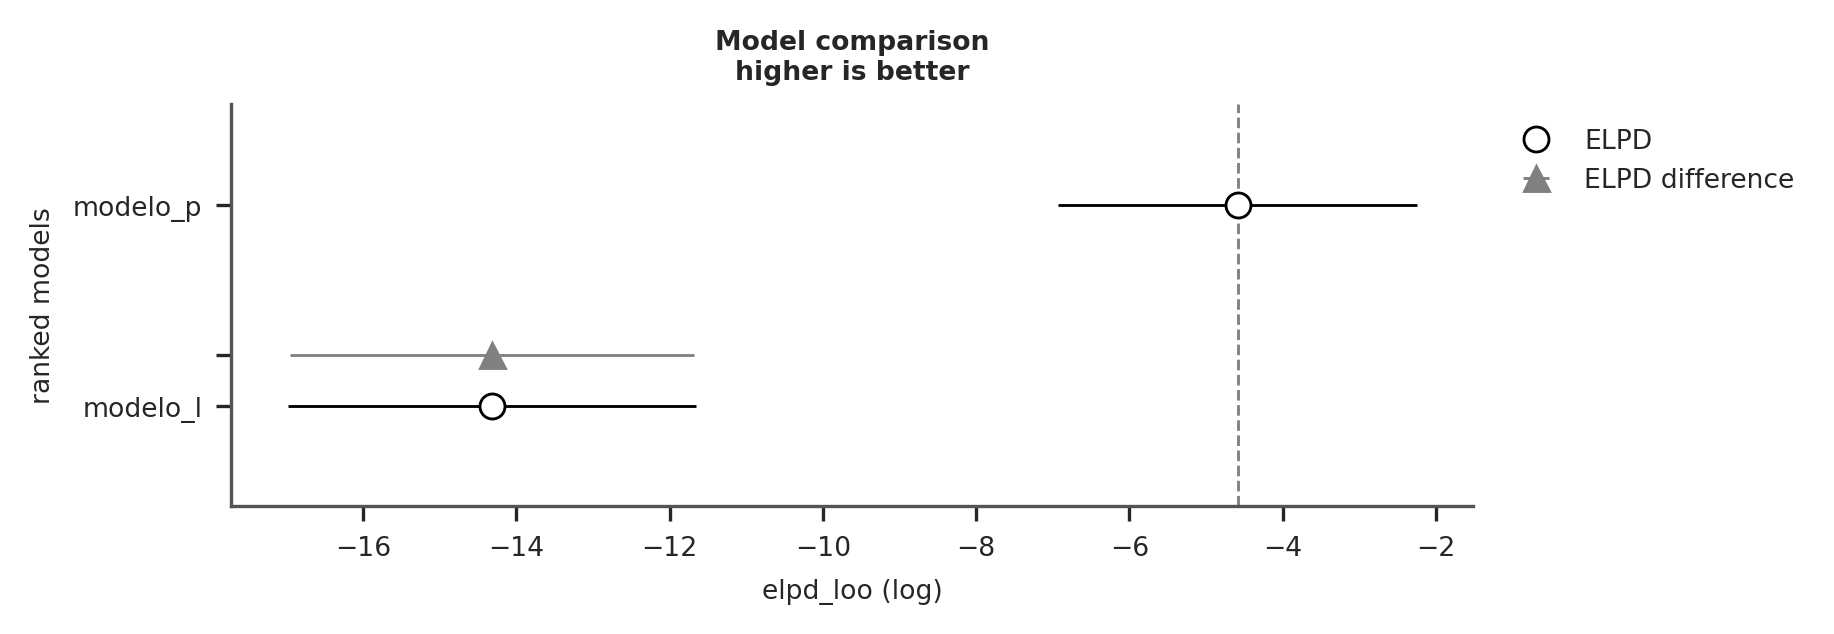

In [16]:
az.plot_compare(cmp_df);

* Los círculos vacíos representan los valores del ELPD y lineas negras el error estándar.
* El valor más alto del ELPD se indica con una línea gris discontinua vertical para facilitar la comparación con otros valores.
* Para todos los modelos, excepto *el mejor*, también obtenemos un triángulo que indica el valor de la diferencia del ELPD entre cada modelo y el *mejor* modelo. La barra de error gris que indica el error estándar de las diferencias entre las estimaciones puntuales.

La forma más sencilla de utilizar los criterios de información es elegir un único modelo. Simplemente elija el modelo con el valor más alto de ELPD. Si seguimos esta regla tendremos que aceptar que el modelo cuadrático es el mejor. Incluso si tenemos en cuenta los errores estandar podemos ver que estos no se solapan. Lo que nos da cierta seguridad que efectivamente los modelos son *diferentes* entre si. Si, en cambio, los errores estándar se superpusieran, deberíamos proporcionar una respuesta más matizada.

## Promedio de modelos

La selección de modelos es atractiva por su simplicidad, pero podríamos estar descartando información sobre la incertidumbre en nuestros modelos. Esto es de alguna manera similar a calcular el posterior completo y luego solo mantener la media del posterior; esto puede conducirnos a confiar _demasiado_ en lo que creemos saber. 

Una alternativa es seleccionar un solo modelo, pero informar y analizar los diferentes modelos junto con los valores de los criterios de información calculados, sus valores de error estándar y quizás también las pruebas predictivas a posteriori. Es importante poner todos estos números y pruebas en el contexto de nuestro problema para que nosotros y nuestra audiencia podamos tener una mejor idea de las posibles limitaciones y deficiencias de los modelos. Para quienes trabajan en el mundo académico, estos elementos se pueden utilizar para agregar elementos a la sección de discusión de un paper, presentación, tesis, etc. Y en la industria esto puede ser útil para informar a clientes sobre las ventajas y limitaciones de las predicciones o conclusiones del modelado.

Otra posibilidad es promediar los modelos. De esta forma estamos introduciendo la incertidumbre que tenemos sobre la bondad de cada modelo. De esta fora podemos generar un metamodelo (y meta-predicciones) usando un promedio pesado de cada modelo. 


In [17]:
idata_w = az.weight_predictions(idatas, weights=[0.35, 0.65])

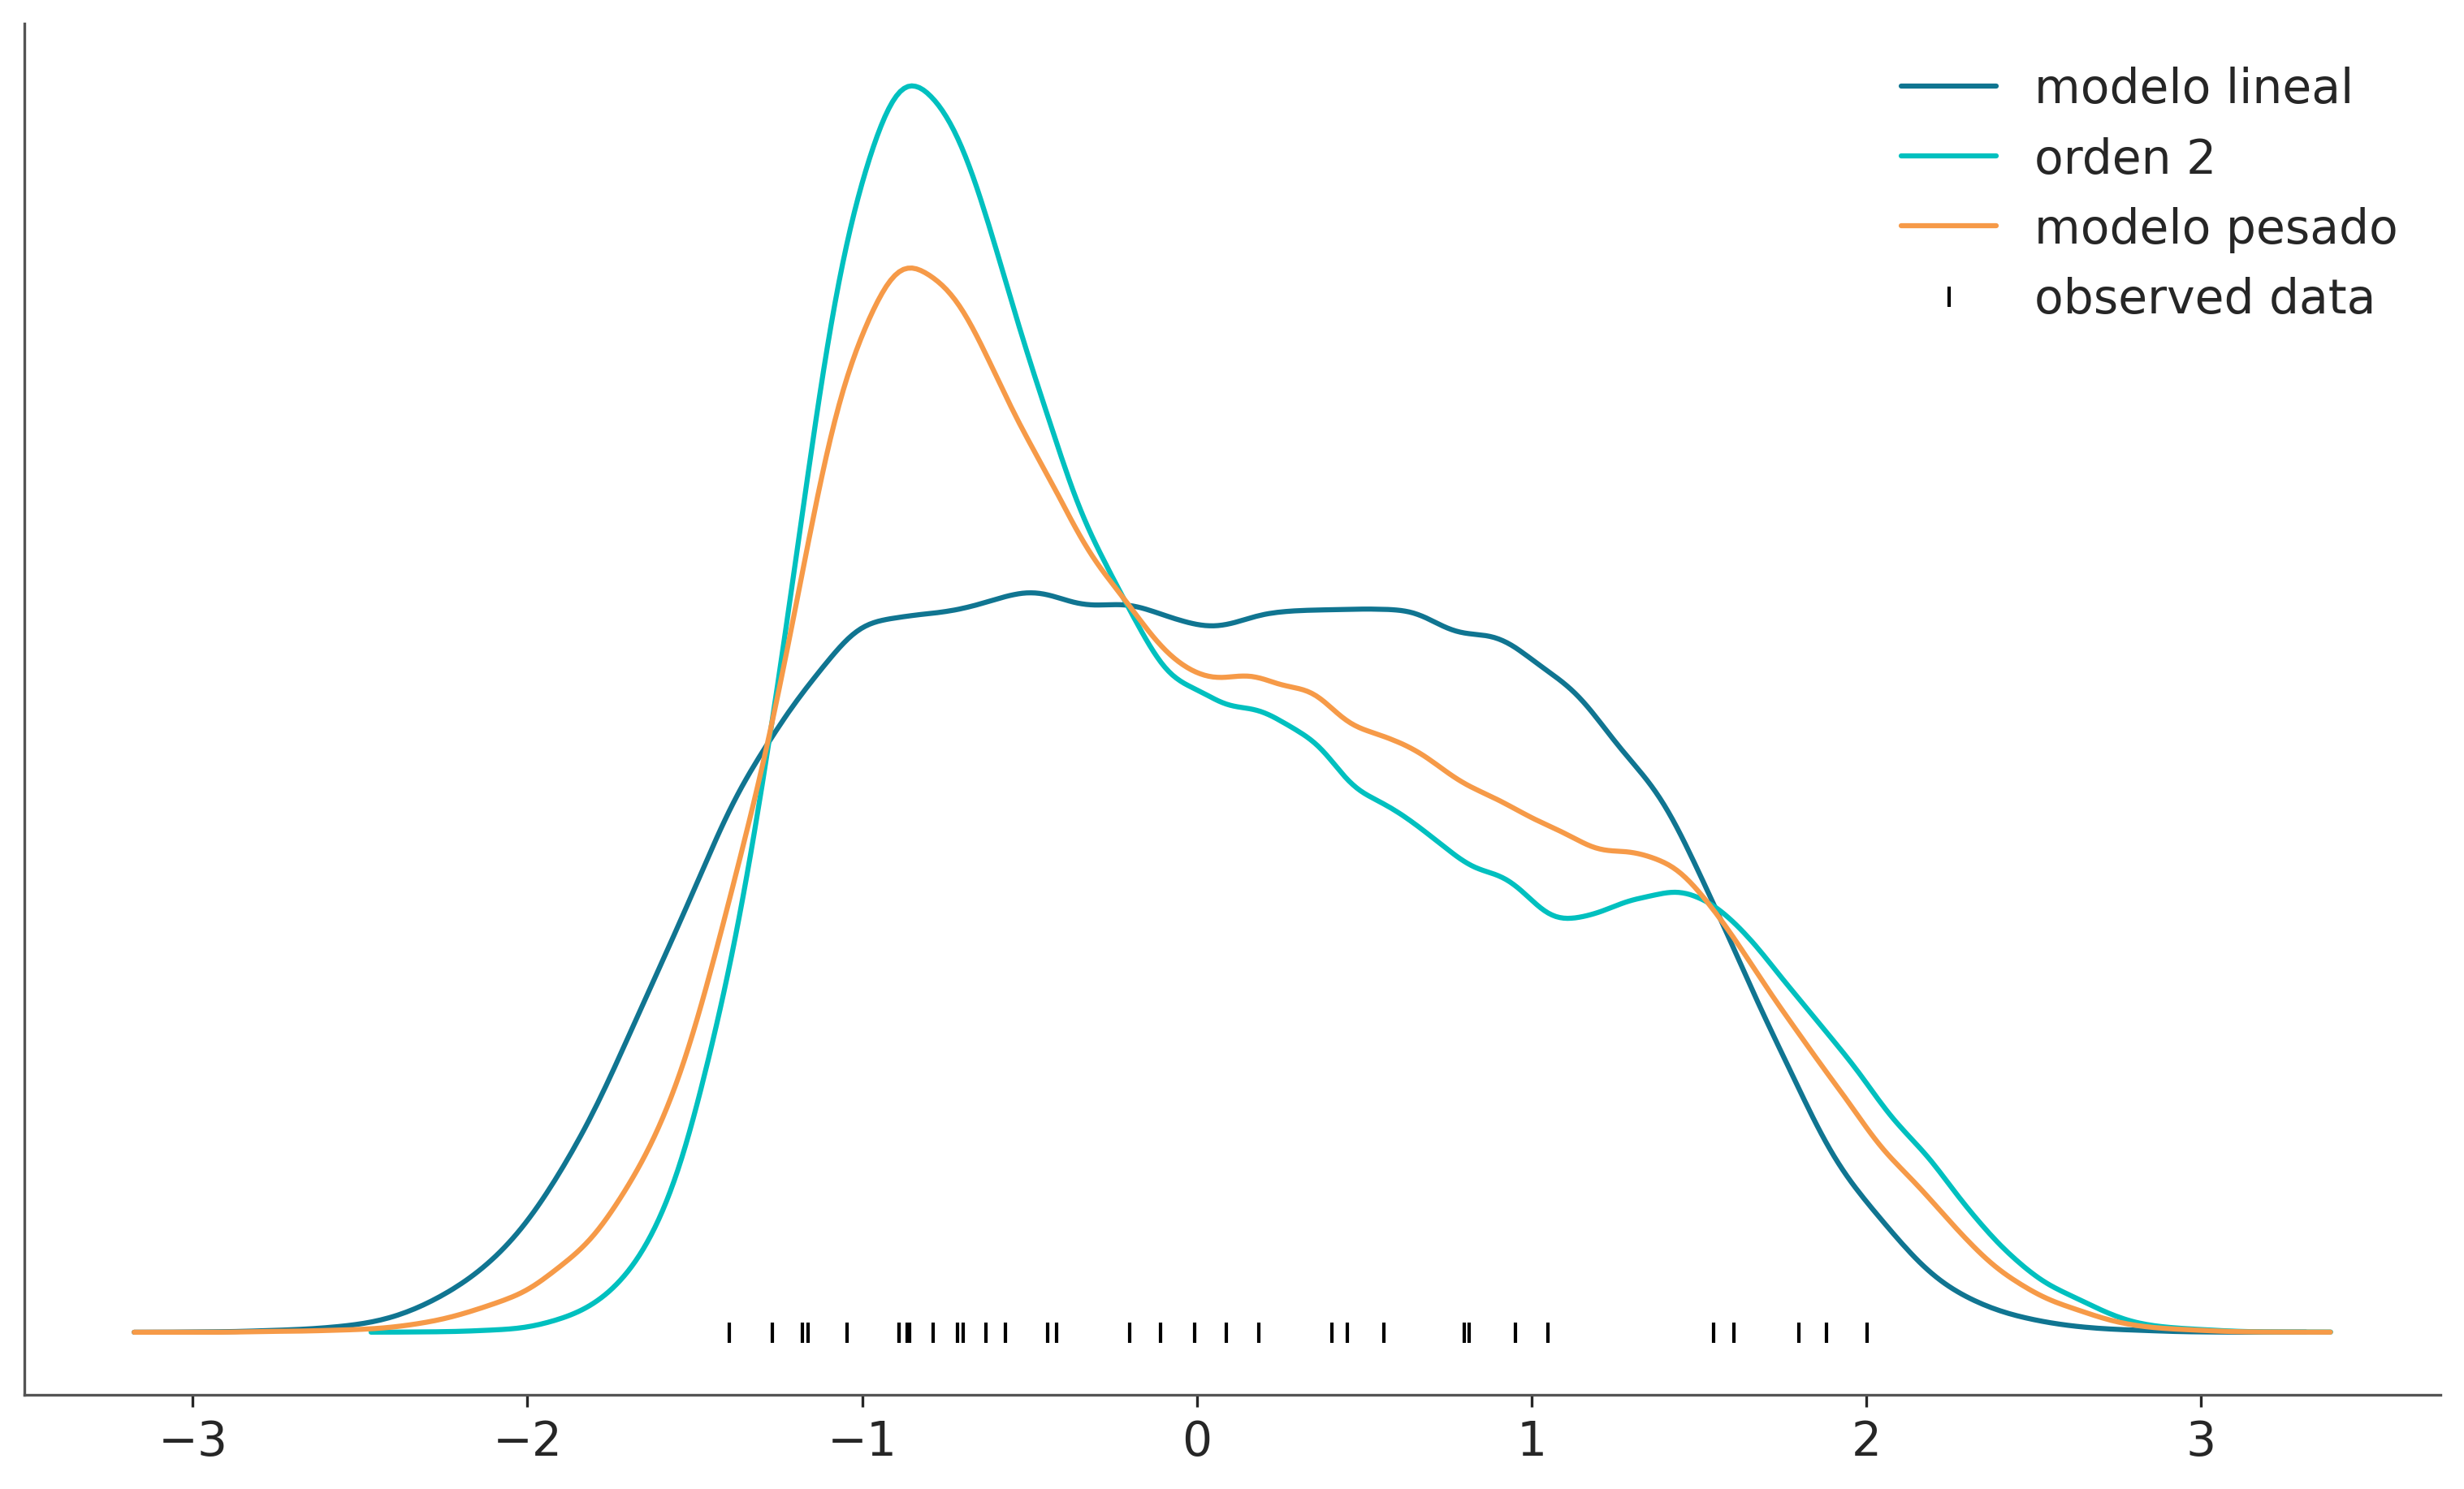

In [18]:
_, ax = plt.subplots(figsize=(10, 6))
az.plot_kde(idata_l.posterior_predictive['y_pred'].values, plot_kwargs={'color':'C0'}, label='modelo lineal', ax=ax)
az.plot_kde(idata_p.posterior_predictive['y_pred'].values, plot_kwargs={'color':'C1'}, label='orden 2', ax=ax)
az.plot_kde(idata_w.posterior_predictive['y_pred'].values, plot_kwargs={'color':'C2'}, label='modelo pesado', ax=ax)

plt.plot(y_c, np.zeros_like(y_c), 'k|', label='observed data')
plt.yticks([])
plt.legend();

Hay otras formas de promediar modelos, como, por ejemplo, construir explícitamente un metamodelo que incluya todos los modelos de interés como casos particulares. Por ejemplo un polinomio de grado 2 contiene como caso particular un modelo lineal, o un modelo jerárquico es la versión continua entre dos extremos un modelo agrupado y uno desagrupado.

## Factores de Bayes

Una alternativa LOO, validación cruzada y los criterios de información son los factores de Bayes. Es común que factores de Bayes aparezcan en la literatura como una alternativa Bayesiana al contraste de hipótesis frecuentista. 

La "manera Bayesiana" de comparar modelos es calcular la _verosimilitud marginal_ de cada modelo $p(y \mid M_k)$, es decir, la probabilidad de los datos observados $Y$ dado el modelo $M_k$. Esta cantidad, la _verosimilitud marginal_, es simplemente la constante de normalización del teorema de Bayes. Podemos ver esto si escribimos el teorema de Bayes y hacemos explícito el hecho de que todas las inferencias dependen del modelo.

$$p (\theta \mid Y, M_k ) = \frac{p(Y \mid \theta, M_k) p(\theta \mid M_k)}{p(Y \mid M_k)}$$

dónde:

* $y$ son los datos
* $\theta$ los parámetros
* $M_k$ un modelo de k modelos competidores

Si nuestro objetivo principal es elegir solo un modelo, el _mejor_, de un conjunto de modelos podemos elegir el que tiene el mayor valor de $p(y \mid M_k)$. Esto está bien si asumimos que **todos los modelos** tienen la misma probabilidad _a priori_. De lo contrario debemos calcular:

$$p(M_k \mid y) \propto p(y \mid M_k) p(M_k)$$

Si en cambio, nuestro objetivo principal es comparar comparar modelos para determinar cuáles son más probables y en qué medida. Esto se puede lograr utilizando los factores de Bayes:

$$FB_{01} = \frac{p(y \mid M_0)}{p(y \mid M_1)}$$

es decir, el cociente entre la verosimilitud marginal de dos modelos. Cuanto mayor sea el FB, _mejor_ el modelo en el numerador ($M_0$ en este ejemplo). Para facilitar la interpretación de los FB, Harold Jeffreys propuso una escala para la interpretación de los Factores de Bayes con niveles de *apoyo* o *fuerza*. Esta es solo una manera de poner números en palabras.

* 1-3: anecdótico
* 3-10: moderado
* 10-30: fuerte
* 30-100: muy fuerte
* $>$ 100: extremo

Hay que tener en cuenta que si se obtiene números por debajo de 1, entonces el soporte es para el modelo en el denominador, también hay tablas disponibles para esos casos. O simplemente podemos tomar la inversa de los valores del valor obtenido.

Es muy importante recordar que estas reglas son solo convenciones, guías simples en el mejor de los casos. Los resultados siempre deben ponerse en el contexto de nuestros problemas y deben ir acompañados de suficientes detalles para que otros puedan evaluar por sí mismos si están de acuerdo con nuestras conclusiones. No es lo mismo la prueba necesaria para asegurar algo en física de partículas, o en un juzgado, o para decidir realziar una evacuación frente a una catástrofe natural que se avecina.

## Algunas observaciones
 

Ahora discutiremos brevemente algunos hechos clave sobre la _verosimilitud marginal_

* El bueno
    * **Navaja de Occam incluida**: Los modelos con más parámetros tienen una penalización mayor que los modelos con menos parámetros. La razón intuitiva es que cuanto mayor es el número de parámetros, más se _extiende_ el _prior_ con respecto al likelihood.


* El malo
    * Para muchas problema la verosimilitud marginal no puede ser calculada analiticamente. Y aproximarla numéricamente suele ser una tarea difícil que suele requerir de métodos especializados. Esto se debe a que es necesario calcular una integral de una función altamente variable en un espacio de parámetros de gran dimensión.
    
$$p(y \mid M_k) = \int_{\theta_k} p(y \mid \theta_k, M_k) \; p(\theta_k | M_k) \; d\theta_k$$

* El feo
    * La probabilidad marginal depende **sensiblemente** de la distribución a prior para los parámetros en cada modelo $p(\theta_k \mid M_k)$.

Es importante notar que *lo bueno* y *lo feo* están relacionados. Usar la verosimilitud marginal para comparar modelos es una buena idea porque ya incluye una penalización para modelos complejos (lo que nos ayuda a prevenir el sobreajuste) y, al mismo tiempo, un cambio en el prior afectará los cálculos de la verosimilitud marginal. Al principio esto suena un poco tonto; ya sabemos que los priors afectan los cálculos (de lo contrario, simplemente podríamos evitarlos), pero el punto aquí es la palabra **sensiblemente**. Estamos hablando que cambios en el posterior que apenas tendrían efecto en el posterior tendrán un gran impacto en el valor de la verosimilitud marginal. 
 
El uso de los FB suele ser una divisoria de aguas entre Bayesianos. La dificultad de su cálculo y la sensibilidad a los priors son algunos de los argumentos. Otra razón es que al igual que lo p-valores y en general las pruebas de hipótesis los BF favorecen el pensamiento dicotómico por sobre la estimación del "tamaño del efecto". Es decir en vez de hacernos preguntas del estilo ¿Cuantos años más de vida puede proporcionar, en promedio, un tratamiento oncológico? terminamos preguntando si la diferencia entre tratar y no tratar a un paciente es "estadísticamente significativa". Ojo que esta última pregunta puede ser útil en algunos contextos, el punto es que en muchos otros contextos, ese tipo de preguntas no es la pregunta más relevante.

## Cálculo de los FB

La verosimilitud marginal generalmente no está disponible en forma cerrada, excepto para algunos modelos. Por esta razón, se han ideado muchos métodos para calcular la probabilidad marginal. Algunos de estos métodos son tan simples e [ingenuos](https://radfordneal.wordpress.com/2008/08/17/the-harmonic -mean-of-the-likelihood-worst-monte-carlo-method-ever/) que funciona muy mal en la práctica. La mayoría de los métodos útiles se han propuesto originalmente en el campo de la mecánica estadística. Esta conexión se explica porque la verosimilitud marginal es análoga a una cantidad central en física estadística conocida como _función de partición_ que a su vez está estrechamente relacionada con otra cantidad muy importante, la _energía libre_. Muchas de las conexiones entre la mecánica estadística y la inferencia bayesiana se resumen [aquí](https://arxiv.org/abs/1706.01428).

### Analiticamente

Para algunos modelos, como el modelo beta-binomial, podemos calcular la verosimilitud marginal analíticamente. Si escribimos este modelo como:

$$\theta \sim Beta(\alpha, \beta)$$
$$y \sim Bin(n=1, p=\theta)$$

la _verosimilitud marginal_ será:

$$p(y) = \binom {n}{h} \frac{B(\alpha + h,\ \beta + n - h)} {B(\alpha, \beta)}$$

dónde:

* $B$ es la [función beta](https://en.wikipedia.org/wiki/Beta_function) no confundirse con la distribución $Beta$
* $n$ es el número de intentos
* $h$ es el número de éxito

Como solo nos importa el valor relativo de la _verosimilitud marginal_ bajo dos modelos diferentes (para los mismos datos), podemos omitir el coeficiente binomial $\binom {n}{h}$, por lo que podemos escribir:

$$p(y) \propto \frac{B(\alpha + h,\ \beta + n - h)} {B(\alpha, \beta)}$$

Esta expresión ha sido codificada en la siguiente celda, pero con un giro. Usaremos la función `betaln` en lugar de la función `beta`, esto se hace para evitar el overflow.

In [19]:
def beta_binom(prior, y):
    """
    Calcula la probabilidad marginal, analíticamente, para un modelo beta-binomial.

     prior : tupla
         tupla de parámetro alfa y beta para el prior (distribución beta)
     y : array
         array con "1" y "0" correspondientes al éxito y falla respectivamente
    """
    alpha, beta = prior
    h = np.sum(y)
    n = len(y)
    p_y = np.exp(betaln(alpha + h, beta + n - h) - betaln(alpha, beta))
    return p_y

Nuestros datos para este ejemplo consisten en 100 "lanzamientos de una moneda" y el mismo número de "caras" y cecas" observadas. Compararemos dos modelos uno con un prior uniforme y otro con un prior _más concentrado_ alrededor de $\theta = 0.5$

In [20]:
y = np.repeat([1, 0], [50, 50])  # 50 "caras" y 50 "cecas"
priors = ((1, 1), (30, 30))

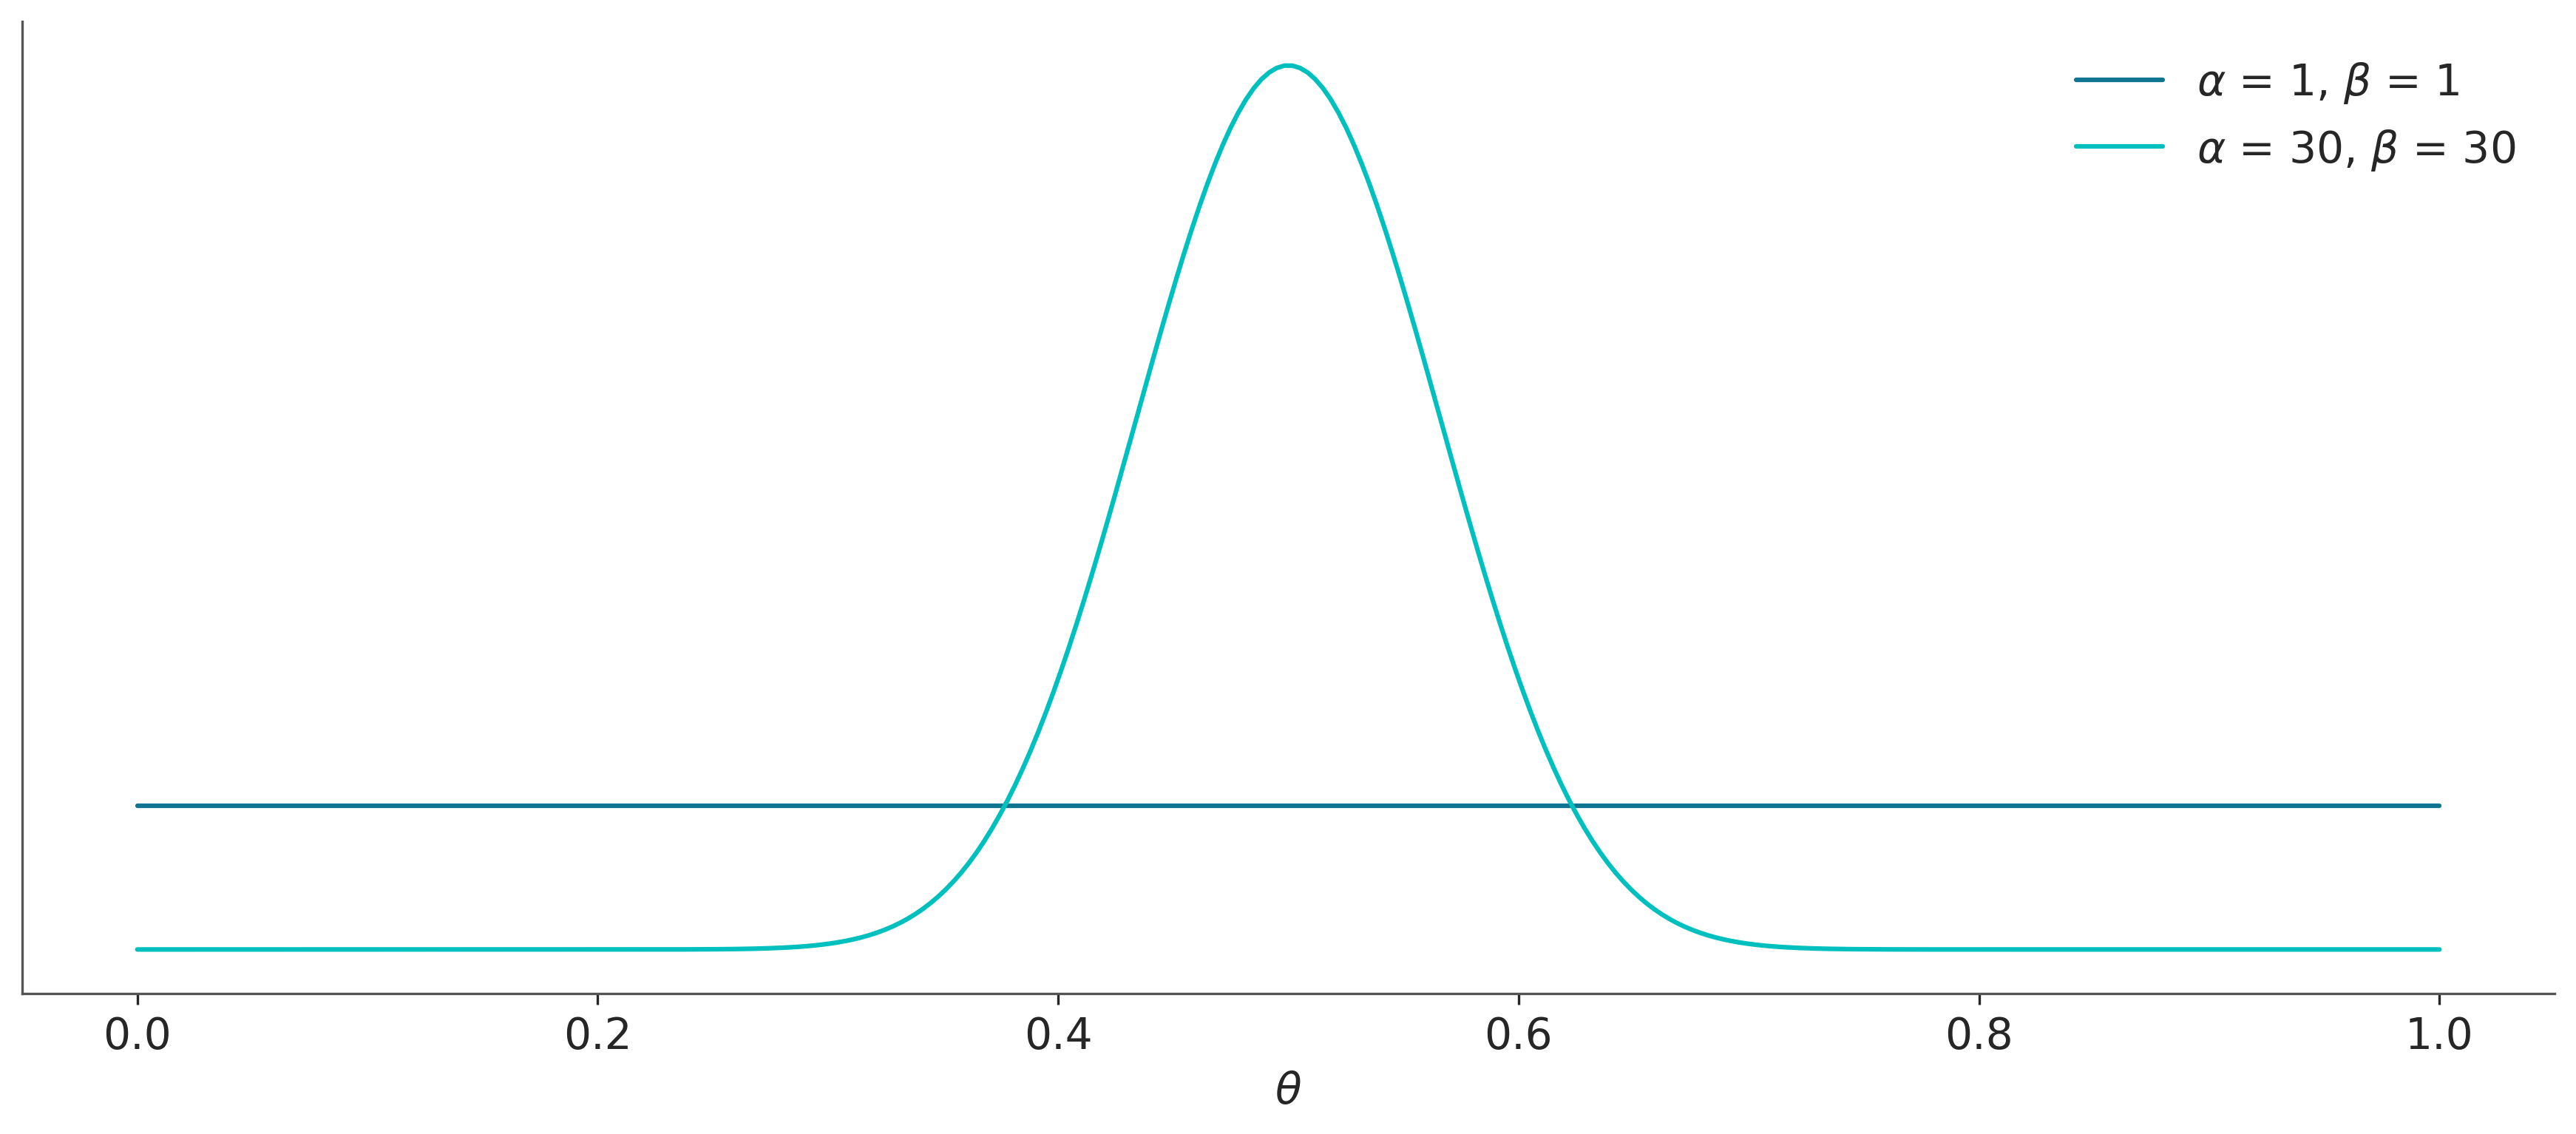

In [21]:
for a, b in priors:
    x = np.linspace(0, 1, 300)
    x_pdf = pz.Beta(a, b).rv_frozen.pdf(x)
    plt.plot(x, x_pdf, label=rf"$\alpha$ = {a:d}, $\beta$ = {b:d}")
    plt.yticks([])
    plt.xlabel("$\\theta$")
    plt.legend()

La siguiente celda devuelve el factor de Bayes

In [22]:
BF = beta_binom(priors[1], y) / beta_binom(priors[0], y)
print(round(BF))

5


Vemos que el modelo con el prior $\text{beta}(30, 30)$, más concentrado, tiene $\approx 5$ veces más apoyo que el modelo con el $\text{beta}(1, 1)$. Esto es esperable ya que el prior para el primer caso se concentra alrededor de $\theta = 0.5$ y los datos $Y$ tienen el mismo número de caras y cruces, es decir acuerdan con un valor de $\theta$ alrededor de 0.5.

### Sequential Monte Carlo

El método Sequential Monte Carlo es un método de meustreo que básicamente progresa mediante una serie de secuencias sucesivas desde el prior al posterior. Un subproducto de este proceso es la estimación de la verosimilitud marginal. En realidad, por razones numéricas, el valor devuelto es el logaritmo de la verosimilitud marginal.

In [23]:
models = []
idatas = []
for alpha, beta in priors:
    with pm.Model() as model:
        a = pm.Beta("a", alpha, beta)
        yl = pm.Bernoulli("yl", a, observed=y)
        idata = pm.sample_smc(random_seed=42)
        models.append(model)
        idatas.append(idata)

Initializing SMC sampler...
Sampling 4 chains in 4 jobs


/home/osvaldo/anaconda3/envs/pymc/lib/python3.10/site-packages/arviz/data/base.py:221: UserWarning: More chains (4) than draws (3). Passed array should have shape (chains, draws, *shape)
  warnings.warn(
Initializing SMC sampler...
Sampling 4 chains in 4 jobs


/home/osvaldo/anaconda3/envs/pymc/lib/python3.10/site-packages/arviz/data/base.py:221: UserWarning: More chains (4) than draws (1). Passed array should have shape (chains, draws, *shape)
  warnings.warn(


In [24]:
BF_smc = np.exp(
    idatas[1].sample_stats["log_marginal_likelihood"].mean()
    - idatas[0].sample_stats["log_marginal_likelihood"].mean()
)
np.round(BF_smc).item()

5.0

Como podemos ver en la celda anterior, ¡SMC da esencialmente la misma respuesta que el cálculo analítico!

Nota: En la celda de arriba calculamos una diferencia (en lugar de una división) porque estamos en la escala logarítmica, por la misma razón tomamos la exponencial antes de devolver el resultado. Finalmente, la razón por la que calculamos la media es porque obtenemos un valor logarítmico de probabilidad marginal por cadena.

La ventaja de usar SMC para calcular la verosimilitud marginal es que podemos usarlo para una gama más amplia de modelos, ya que ya no necesitamos conocer una expresión en forma cerrada. El costo que pagamos por esta flexibilidad es un cálculo más costoso. Además hay que tener en cuenta que SMC (con un kernel Metropolis independiente implementado en PyMC) no es tan eficiente como NUTS. A medida que aumenta la dimensionalidad del problema, una estimación más precisa de la posterior y la _verosimilitud marginal_ requerirá un mayor número de muestras del posterior.

## Factores de bayes e inferencia

Hasta ahora hemos usado los factores de Bayes para juzgar qué modelo parece ser mejor para explicar los datos, y obtenemos que uno de los modelos es $\approx 5$ veces _mejor_ que el otro.

Pero, ¿qué pasa con el posterior que obtenemos de estos modelos? ¿Qué tan diferentes son?

In [25]:
az.summary(idatas[0], var_names="a", kind="stats").round(2)

,mean,sd,hdi_3%,hdi_97%
a,0.5,0.05,0.4,0.59


In [26]:
az.summary(idatas[1], var_names="a", kind="stats").round(2)

,mean,sd,hdi_3%,hdi_97%
a,0.5,0.04,0.42,0.57


Podemos argumentar que los resultados son bastante similares, tenemos el mismo valor medio para $\theta$ y un posterior ligeramente más ancho para `model_0`, como se esperaba ya que este modelo tiene un prior más amplio. También podemos verificar la distribución predictiva posterior para ver qué tan similares son.

In [27]:
ppc_0 = pm.sample_posterior_predictive(idatas[0], model=models[0]).posterior_predictive
ppc_1 = pm.sample_posterior_predictive(idatas[1], model=models[1]).posterior_predictive

Sampling: [yl]


Sampling: [yl]


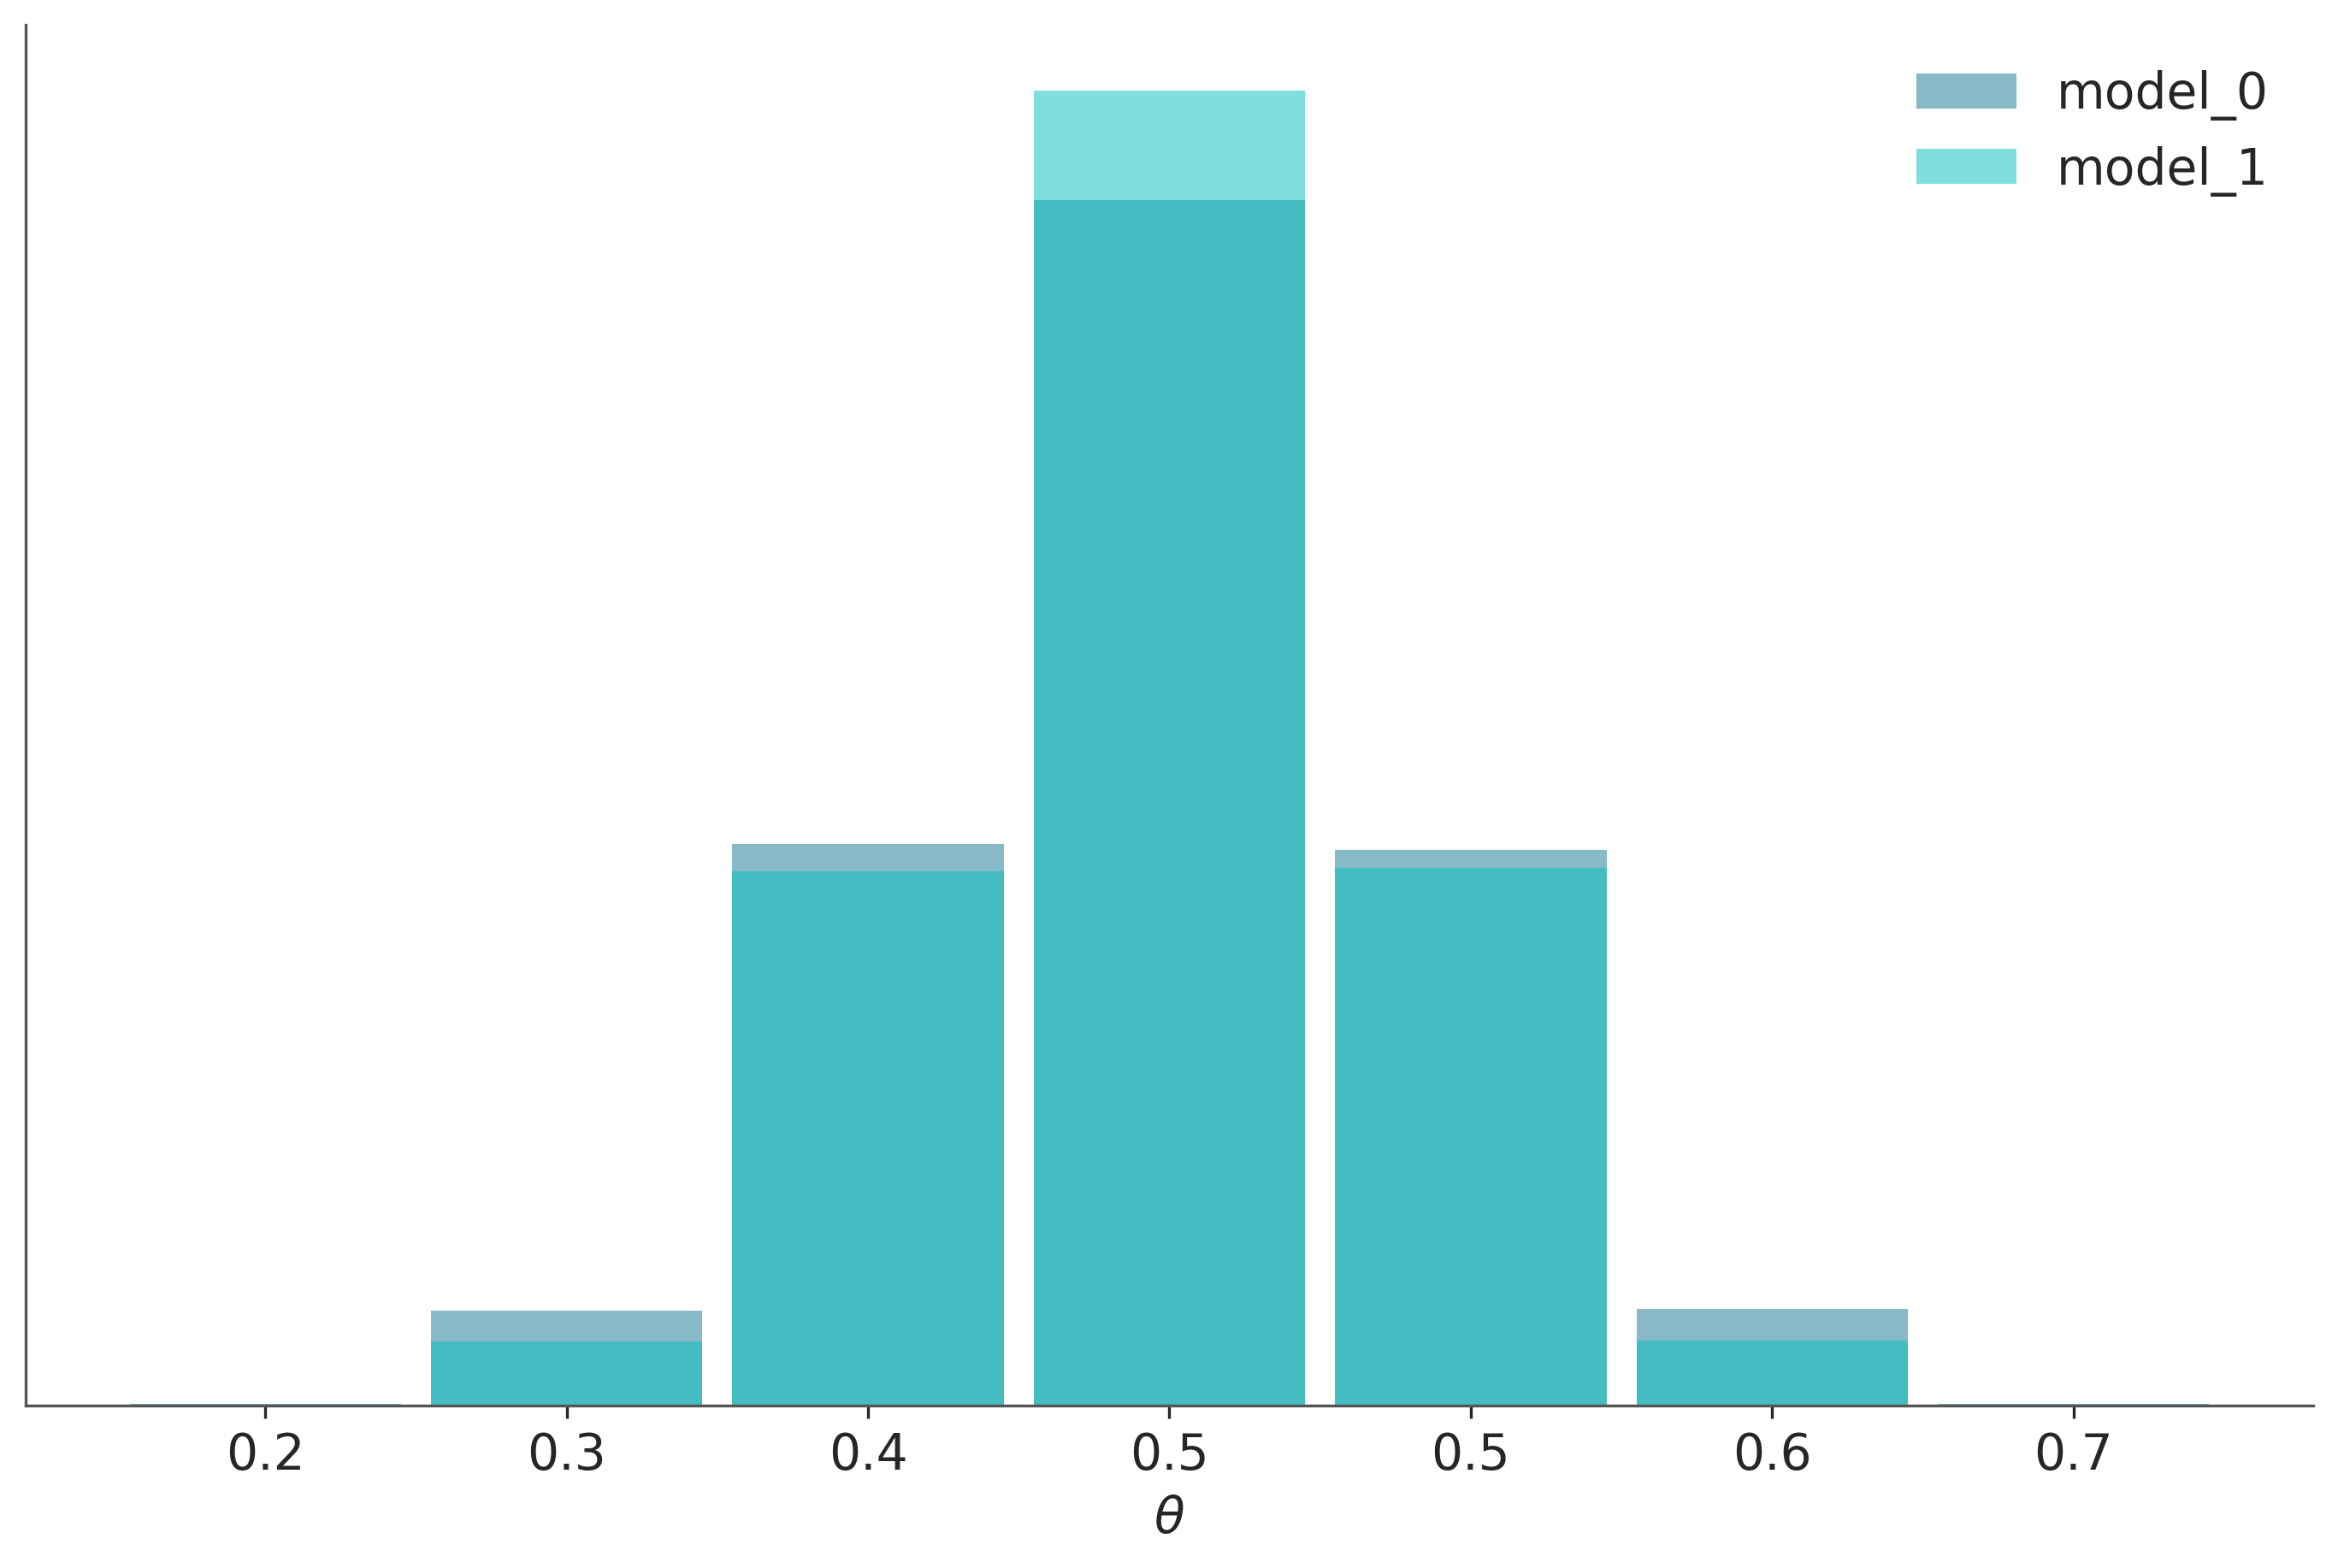

In [28]:
_, ax = plt.subplots(figsize=(9, 6))

bins = np.linspace(0.2, 0.8, 8)
ax = az.plot_dist(
    ppc_0["yl"].mean("yl_dim_2"),
    label="model_0",
    kind="hist",
    hist_kwargs={"alpha": 0.5, "bins": bins},
)
ax = az.plot_dist(
    ppc_1["yl"].mean("yl_dim_2"),
    label="model_1",
    color="C1",
    kind="hist",
    hist_kwargs={"alpha": 0.5, "bins": bins},
    ax=ax,
)
ax.legend()
ax.set_xlabel("$\\theta$")
ax.xaxis.set_major_formatter(FormatStrFormatter("%0.1f"))
ax.set_yticks([]);

En este ejemplo, los datos observados son más consistentes con el `modelo_1`, por que el prior se concentra en torno al valor correcto de $\theta$, mientras que el `modelo_0`, asigna la misma probabilidad a todos los valores posibles de $\theta$. Esta diferencia entre los modelos es capturada por el factor de Bayes. Podríamos decir que los factores de Bayes miden qué modelo, en su conjunto, es mejor para explicar los datos. Y esto incluye los detalles del prior, sin importar cuan similares son las predicciones de los modelos. En muchos escenarios lo que nos interesa al comparar modelos es cuan similares son las predicciones. Que es lo que estima LOO o validación cruzada.

## Cociente de  Savage-Dickey

Para los ejemplos anteriores hemos comparado dos modelos beta-binomiales, podríamos haber comparado dos modleos completamente diferentes. Pero hay veces que queremos comparar una hipótesis nula H_0 (o modelo nulo) contra una alternativa H_1. Por ejemplo, para responder a la pregunta _¿Está sesgada esta moneda?_, podríamos comparar el valor $\theta = 0.5$ (que representa el no-sesgo) con el resultado de un modelo en el que permitimos que $\theta$ varíe. Para este tipo de comparación, el modelo nulo está anidado dentro de la alternativa, lo que significa que el valor nulo es un valor particular del modelo que estamos construyendo. En esos casos, calcular el factor de Bayes es muy fácil y no requiere ningún método especial. Solo necesitamos comparar el prior y el posterior evaluados en el valor nulo (por ejemplo $\theta = 0.5$ ), bajo el modelo alternativo. Podemos ver que esto es cierto a partir de la siguiente expresión:


$$
BF_{01} = \frac{p(y \mid H_0)}{p(y \mid H_1)} \frac{p(\theta=0.5 \mid y, H_1)}{p(\theta=0.5 \mid H_1)}
$$

Que es cierta [solo](https://statproofbook.github.io/P/bf-sddr) cuando H_0 es un caso particular de H_1.

Hagámoslo con PyMC y ArviZ. Solo necesitamos obtener muestras del prior y del posterior para un modelo. Probemos con el modelo beta-binomial con prior uniforme.

In [29]:
with pm.Model() as model_uni:
    a = pm.Beta("a", 1, 1)
    yl = pm.Bernoulli("yl", a, observed=y)
    idata_uni = pm.sample(2000, random_seed=42)
    idata_uni.extend(pm.sample_prior_predictive(8000))

Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (4 chains in 4 jobs)
NUTS: [a]


Sampling 4 chains for 1_000 tune and 2_000 draw iterations (4_000 + 8_000 draws total) took 2 seconds.
Sampling: [a, yl]


Y ahora llamamos a la función de ArviZ `az.plot_bf`

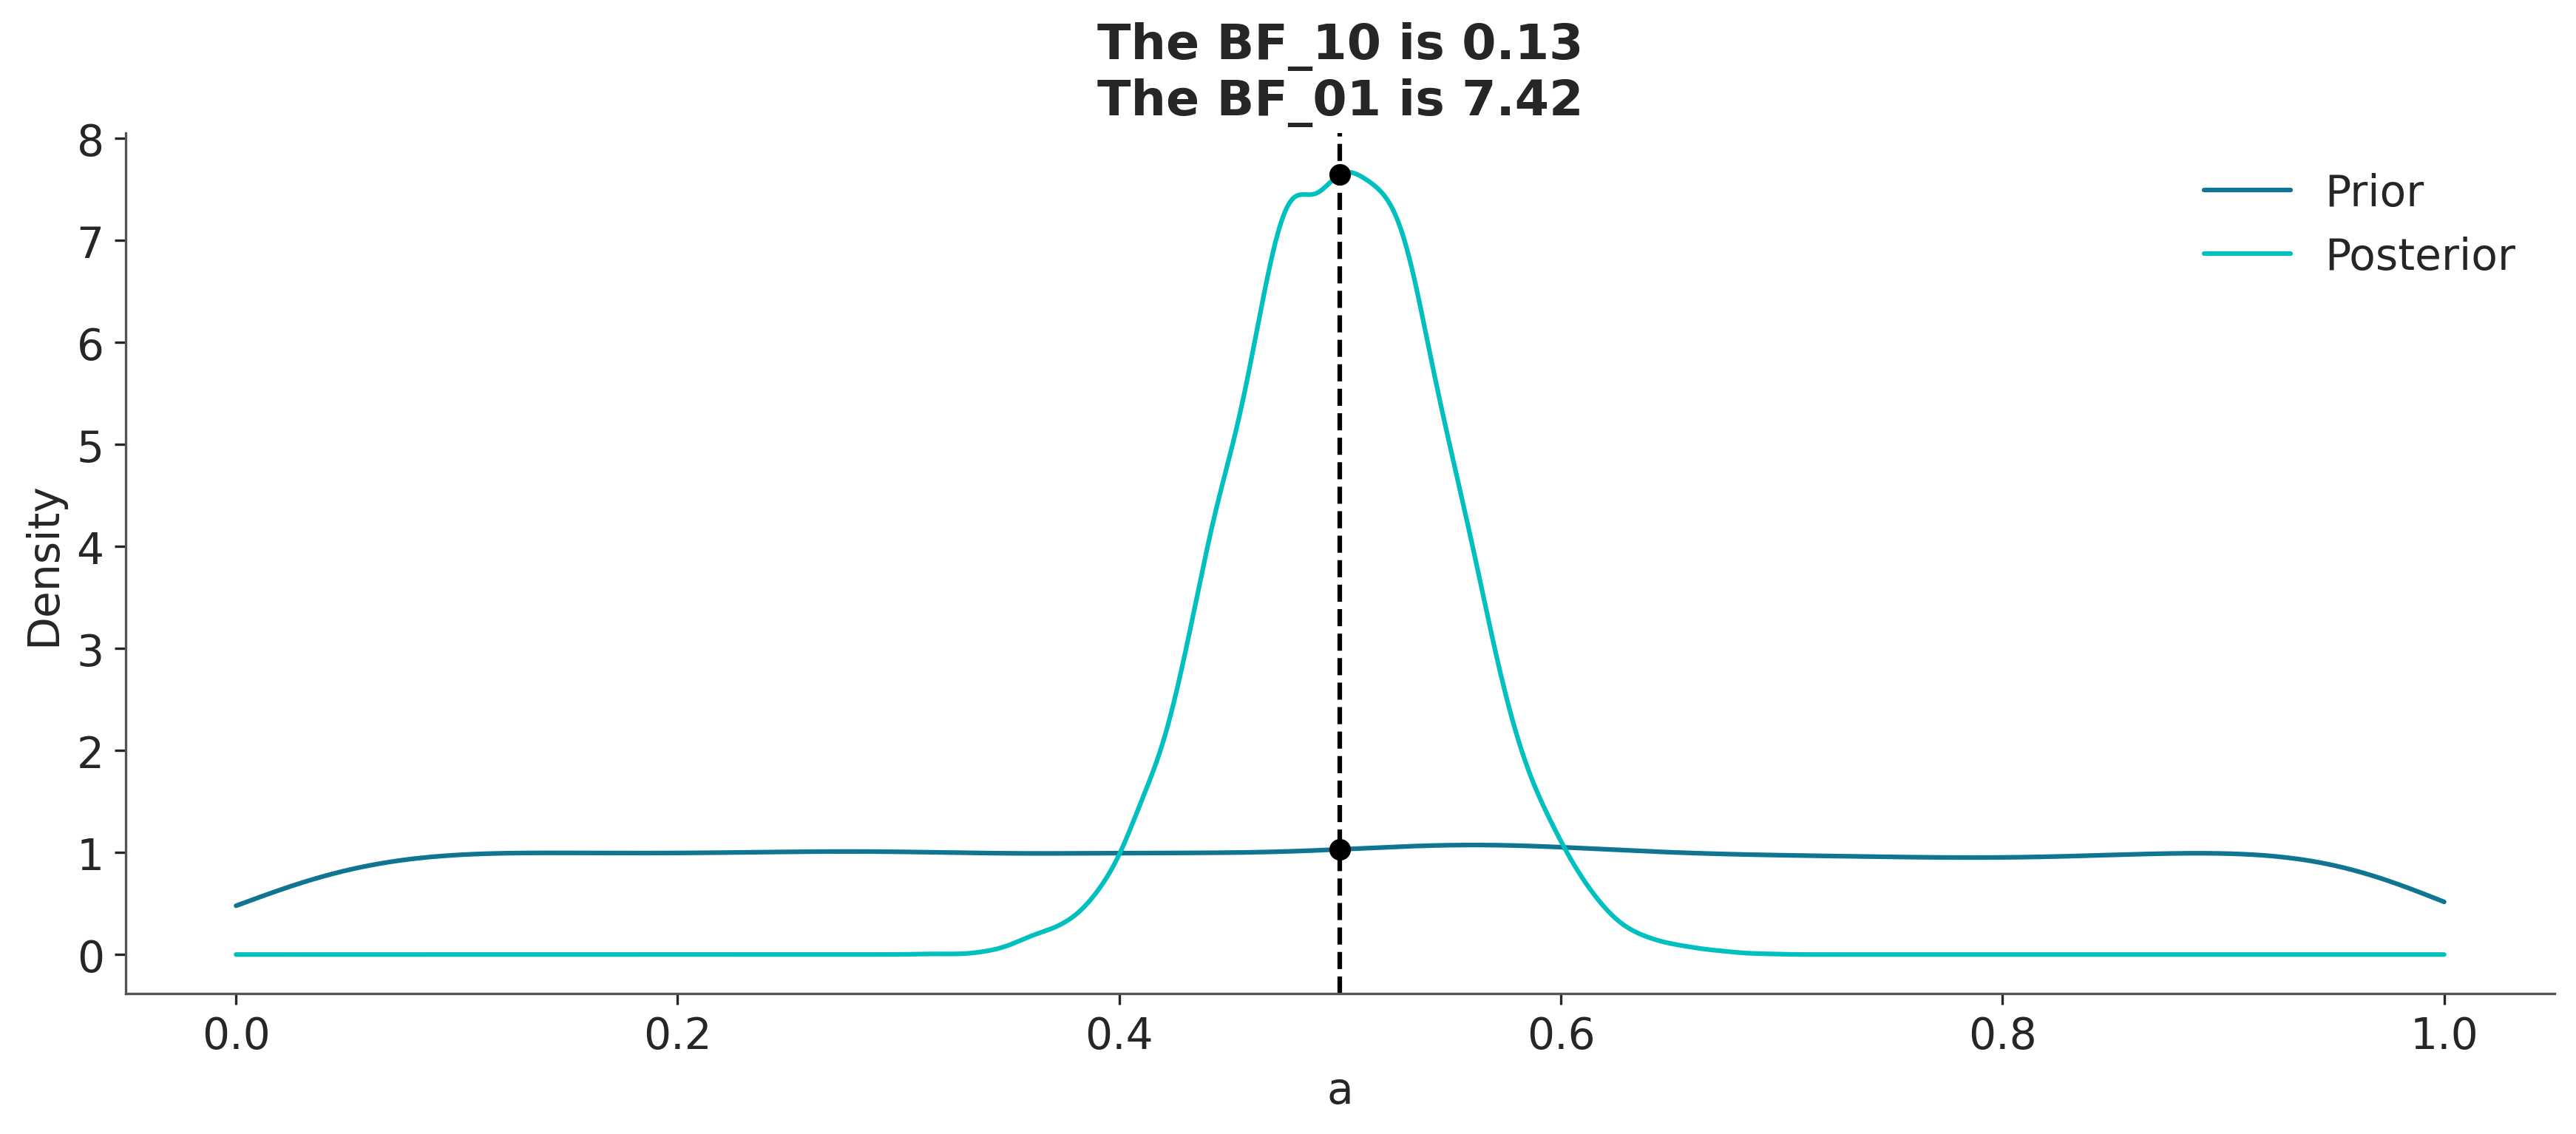

In [30]:
az.plot_bf(idata_uni, var_name="a", ref_val=0.5);

El gráfico muestra un KDE para el prior (azul) y otro para el posterior (turquesa). Los dos puntos negros muestran que evaluamos ambas distribuciones en el valor 0.5. Podemos ver que el factor de Bayes a favor de la hipótesis nula, BF_01, es $\approx 8$, lo que podemos interpretar como una _evidencia moderada_ a favor de la hipótesis nula (ver la escala de Jeffreys que discutimos antes).

Como ya comentamos, los factores de Bayes miden qué modelo, en su conjunto, es mejor para explicar los datos. Y esto incluye el prior, incluso si el prior tiene un impacto relativamente bajo en el cómputo del posterior. También podemos ver este efecto del prior al comparar un segundo modelo con el modelo nulo.

Si en cambio nuestro modelo fuera un beta-binomial con beta prior (30, 30), el BF_01 sería más bajo (_anecdótico_ en la escala de Jeffrey). Esto se debe a que, según este modelo, el valor de $\theta=0.5$ es mucho más probable priori que para un prior uniforme y, por lo tanto, el posterior y el prior serán mucho más similares. Es decir, no hay demasiada _sorpresa_ al ver la que el posterior se concentra alrededor de 0.5 después de recopilar datos.

Vamos a calcularlo para verlo por nosotros mismos.

In [31]:
with pm.Model() as model_conc:
    a = pm.Beta("a", 30, 30)
    yl = pm.Bernoulli("yl", a, observed=y)
    idata_conc = pm.sample(2000, random_seed=42)
    idata_conc.extend(pm.sample_prior_predictive(8000))

Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (4 chains in 4 jobs)
NUTS: [a]


Sampling 4 chains for 1_000 tune and 2_000 draw iterations (4_000 + 8_000 draws total) took 2 seconds.
Sampling: [a, yl]


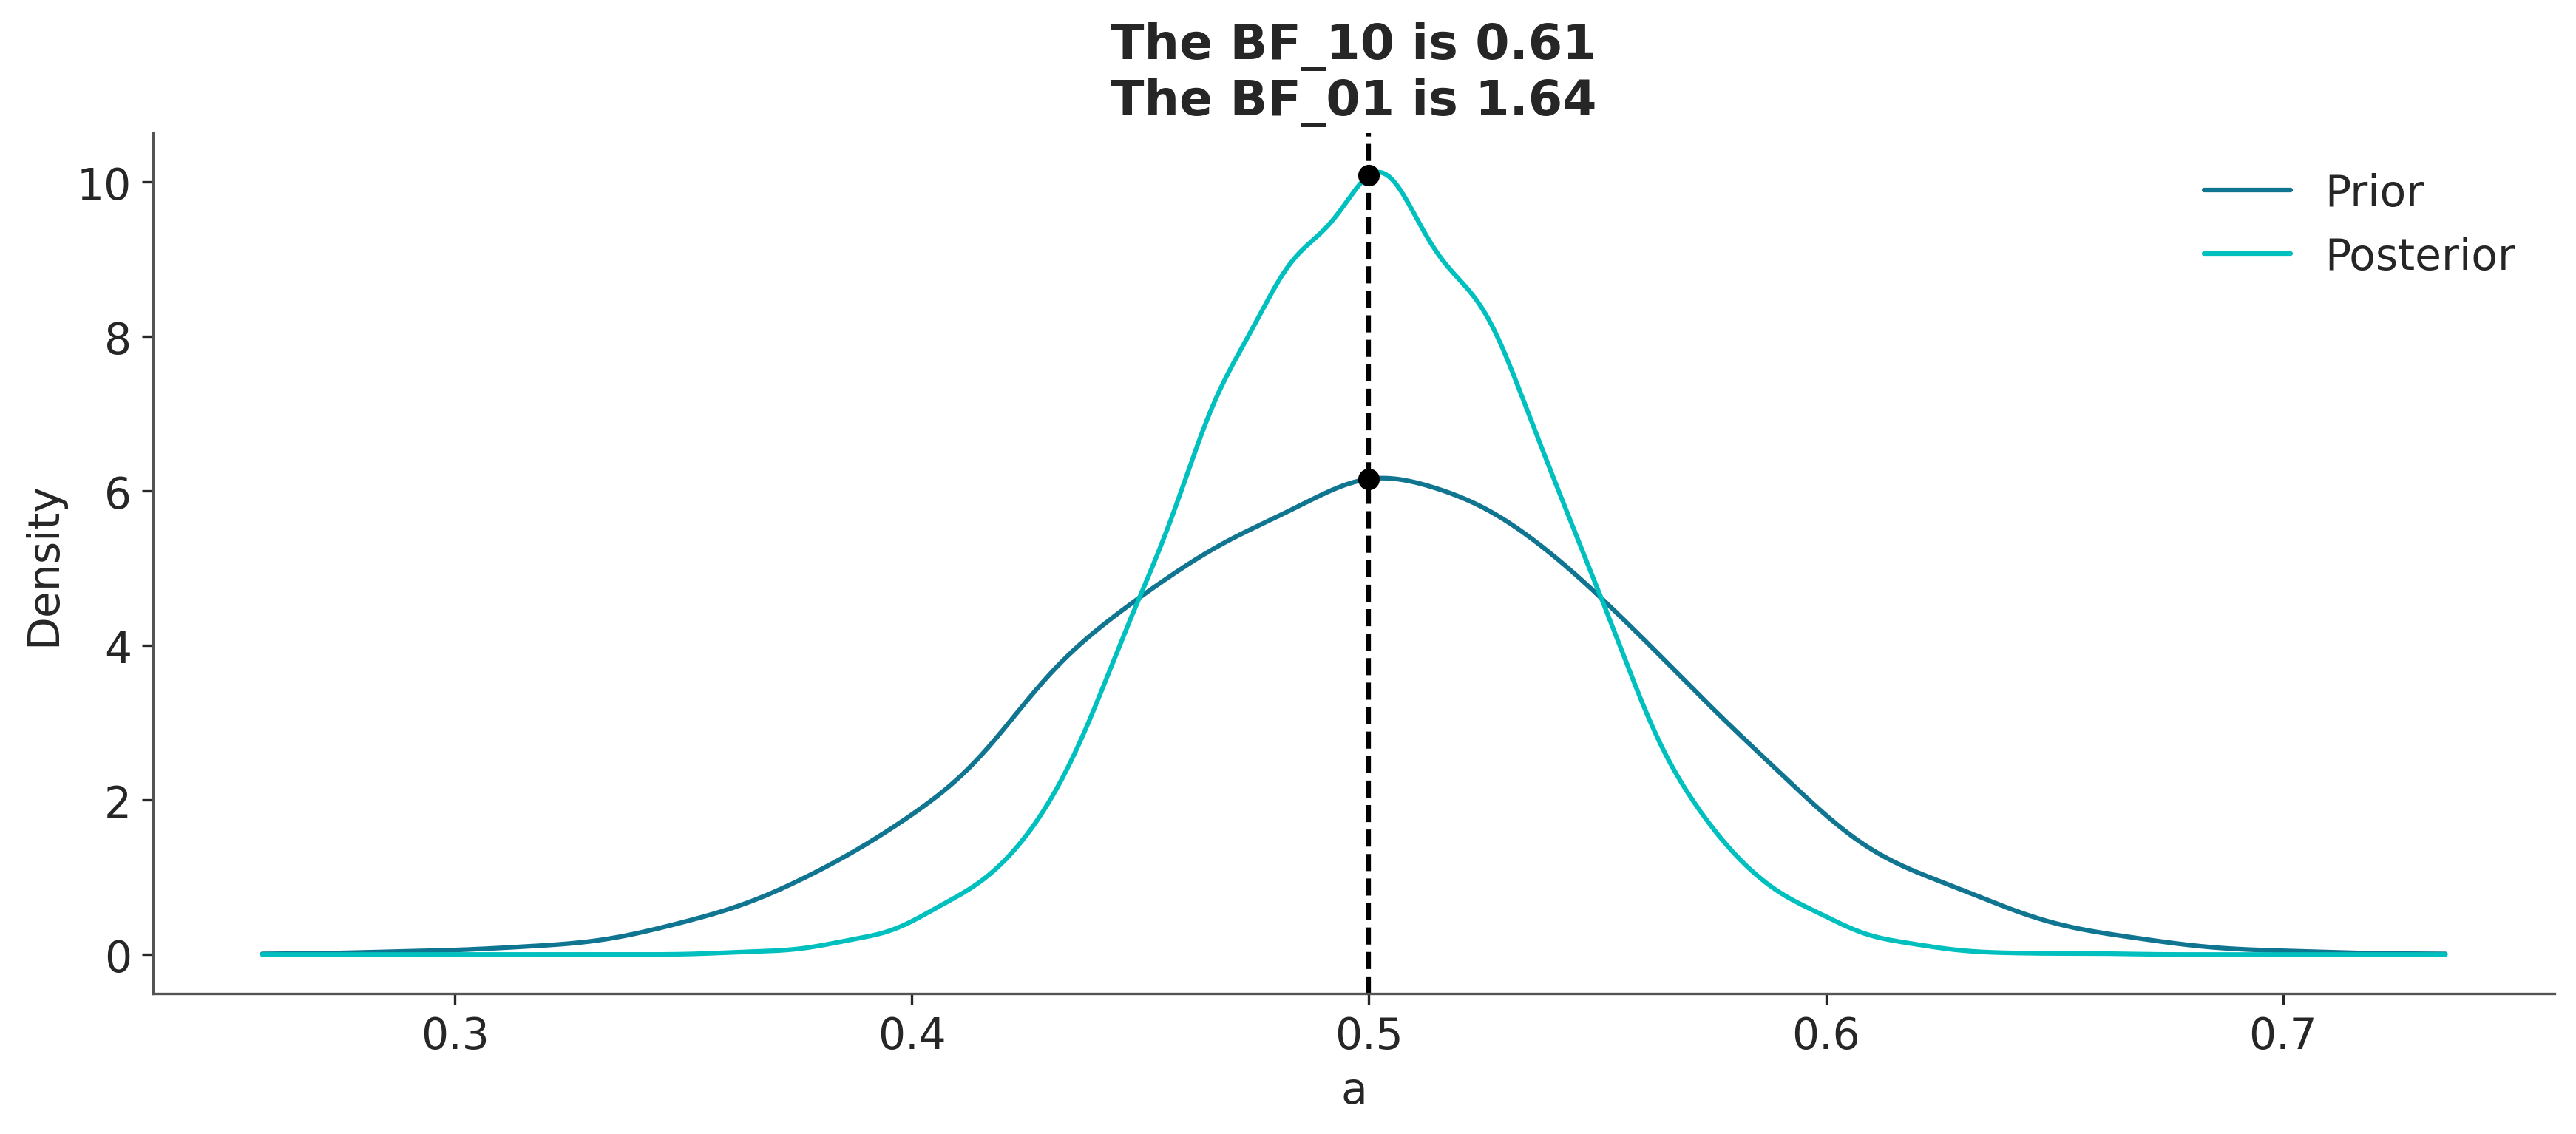

In [32]:
az.plot_bf(idata_conc, var_name="a", ref_val=0.5);